# Introducción

El operador de telecomunicaciones Interconnect desea pronosticar la tasa de cancelación de sus clientes. Si se identifica que un usuario o usuaria está considerando darse de baja, se le ofrecerán códigos promocionales y planes especiales para intentar retenerlo. El equipo de marketing de Interconnect ha recopilado datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

En este proyecto, se realizará un análisis exploratorio de los datos proporcionados para evaluar su calidad y consistencia. A partir de este análisis, **se definirá una estrategia para seleccionar el modelo de predicción más adecuado** para identificar a los posibles clientes que puedan desertar.

# Inicialización

Antes de iniciar el análisis y modelado de datos, se importaron diversas librerías especializadas que facilitan cada etapa del proceso. El código utiliza herramientas esenciales en Python: pandas y numpy para la manipulación y análisis de datos, y seaborn junto con matplotlib.pyplot para la creación de gráficos y visualizaciones. 

In [1]:
# Importación de librerías para manejo de datos
import pandas as pd
import numpy as np

# Importación de librerías para visualización
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

import re
from dateutil.relativedelta import relativedelta

import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
#from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

## Carga de datos

A continuación, se procede con la carga de los cuatro archivos que contienen la información recopilada de cada usuario.

In [2]:
# Carga de datos
try:
    contract = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_provider/contract.csv')
    internet = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_provider/internet.csv')
    personal = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_provider/personal.csv')
    phone = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_provider/phone.csv')

except:
    contract = pd.read_csv('/final_provider/contract.csv')
    internet = pd.read_csv('/final_provider/internet.csv')
    personal = pd.read_csv('/final_provider/personal.csv')
    phone = pd.read_csv('/final_provider/phone.csv')

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

## Exploración inicial

Para facilitar y unificar la exploración de cada conjunto de datos, se definirá una función que presenta un resumen básico de su contenido, permitiendo entender rápidamente la estructura y la calidad de los datos. Esta función muestra las dimensiones (número de filas y columnas), proporciona información detallada sobre los tipos de datos y la cantidad de valores no nulos, calcula y reporta la cantidad de valores duplicados, y verifica si todos los usuarios del conjunto están presentes en el dataset `contract`, que se considera el conjunto base. Finalmente, muestra las primeras cinco filas del DataFrame para ofrecer una vista previa de los datos.

In [3]:
# Función para mostrar resumen básico de conjuntos
def df_summary(df):
    print(f"Dimensiones: {df.shape}\n")
    print("Información:")
    df.info()
    print(f"\nNúmero de valores duplicados: {df.duplicated().sum()}")
    print(f"Se ha encontrado a todos los usuarios: {internet['customerID'].isin(contract['customerID']).all()}\n")
    display(df.head(5)) 

### Conjunto de datos `contract`

In [4]:
# Resumen básico del conjunto 'contract'
df_summary(contract)

Dimensiones: (7043, 8)

Información:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Número de valores duplicados: 0
Se ha encontrado a todos los usuarios: True



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


El dataset `contract` cuenta con 8 columnas y 7,043 filas; cada fila representa a un usuario, por lo que se dispone de información de un total de 7,043 usuarios de Interconnect. Cada columna contiene la siguiente información:

-    `customerID`: ID del cliente.
-    `BeginDate`: fecha de inicio del contrato.
-    `EndDate`: fecha de cancelación del contrato; el valor "No" indica que el contrato no ha finalizado.
-    `Type`: tipo de contrato, ya sea mensual o de 1 o 2 años.
-    `PaperlessBilling`: facturación electrónica o en papel.
-    `MonthlyCharges`: cargo mensual.
-    `TotalCharges`: cargo total acumulado desde el inicio de la suscripción.

Se observa que las columnas `BeginDate` y `MonthlyCharges` tienen tipos de datos incorrectos y requieren ser transformadas a datetime y float, respectivamente. En la columna `EndDate` hay datos de tipo fecha y de tipo texto.

De modo preliminar, se transformará la variable `TotalCharges` a formato float para poder analizar la distribución de sus valores.

In [5]:
# Transformación a tipo float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

# Comprobación de cambio de tipo y generación de valores ausentes
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [6]:
# Visualización de observaciones con valores ausentes
contract[contract['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Es llamativo que todas las observaciones con datos ausentes correspondan a la fecha de inicio 2020-02-01. A continuación, se verificará si todos los usuarios que comenzaron en esa fecha presentan datos ausentes.

In [7]:
# Comparación de subconjuntos con fecha '2020-02-01' y valores ausentes
subset1 = contract[contract['BeginDate'] == '2020-02-01']
subset2 = contract[contract['TotalCharges'].isna()]

print(f"El subconjunto de 2020-02-01 es igual al de los que NaN:", subset1.equals(subset2))

El subconjunto de 2020-02-01 es igual al de los que NaN: True


Es posible que, al tratarse de la última fecha considerada para construir el conjunto de datos, en ese momento aún no se hubieran generado cargos, lo que terminaría convirtiéndose en datos ausentes. Estos valores se procesarán posteriormente.

A continuación, se presentan gráficos de las distintas características para obtener una visión más completa de su distribución.

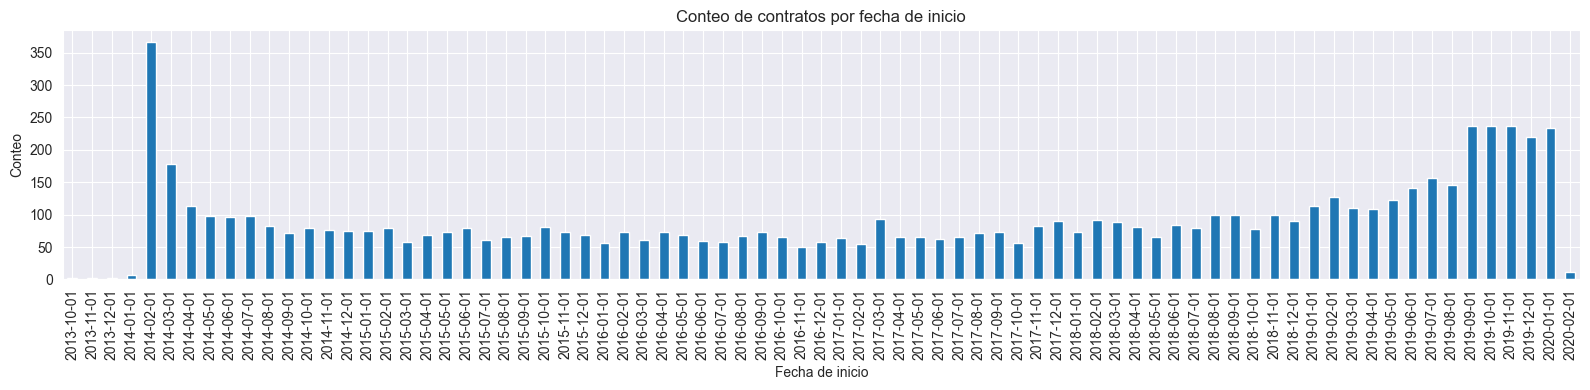

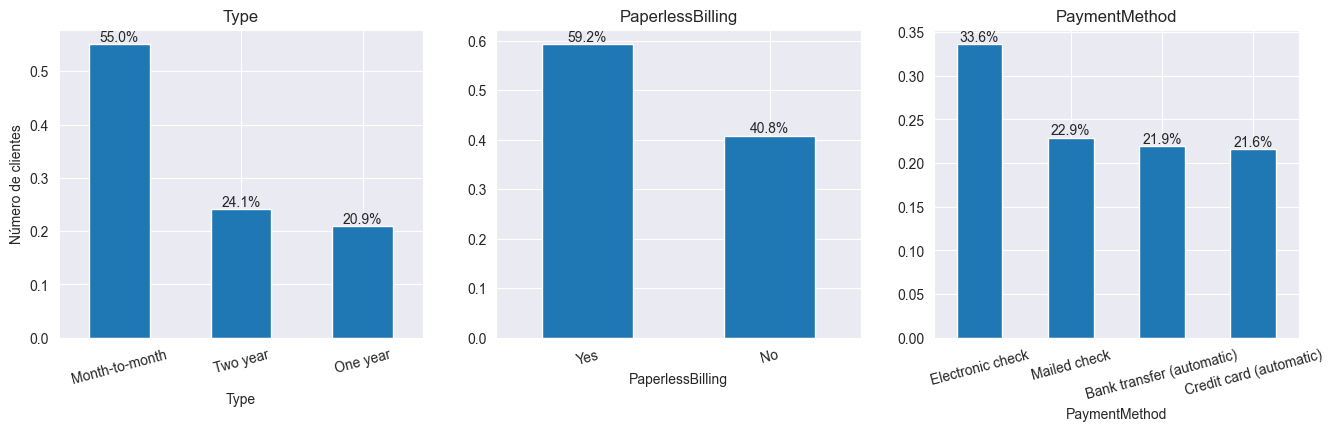

In [8]:
# Conteo de contratos por cada fecha de inicio
date_counts = contract['BeginDate'].value_counts().sort_index()

# Creación de gráfico de barras
plt.figure(figsize=(16, 4))
date_counts.plot(kind='bar')
plt.title('Conteo de contratos por fecha de inicio')
plt.xlabel('Fecha de inicio')
plt.ylabel('Conteo')
plt.tight_layout()
plt.show()

# Histogramas para variables categóricas
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_ylabel('Número de clientes')

for idx, col in enumerate(['Type', 'PaperlessBilling', 'PaymentMethod']):
    counts = contract[col].value_counts(normalize=True)
    bars = counts.plot(kind='bar', ax=ax[idx], title=col, rot=15)
    
    # Etiquetas de porcentaje
    labels = [f'{100 * v:.1f}%' for v in counts]
    ax[idx].bar_label(ax[idx].containers[0], labels=labels)

,MonthlyCharges,TotalCharges
count,7043.00,7032.00
mean,64.76,2283.30
std,30.09,2266.77
min,18.25,18.80
25%,35.50,401.45
50%,70.35,1397.48
75%,89.85,3794.74
max,118.75,8684.80


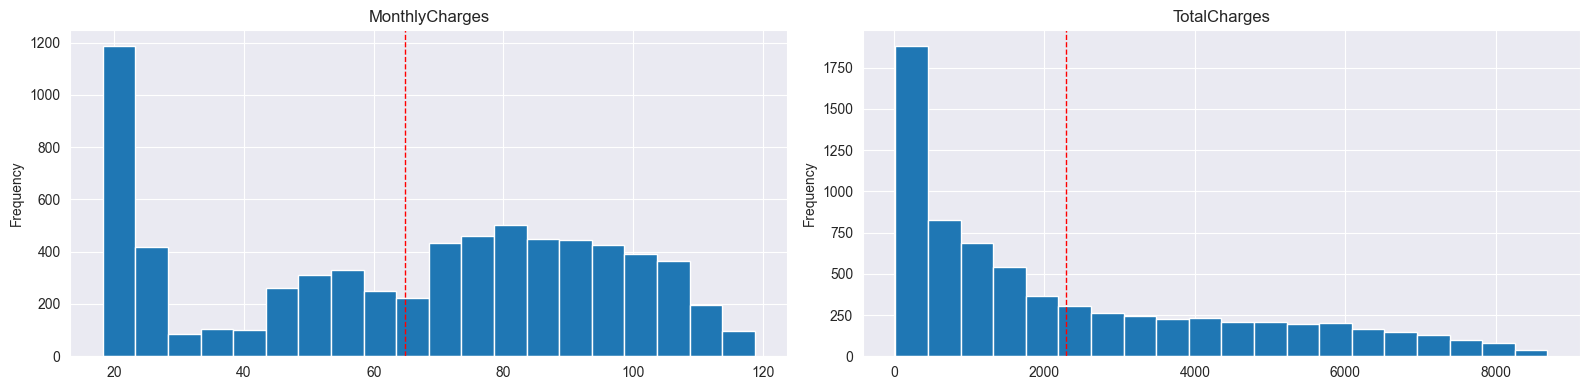

In [9]:
# Resumen estadísticos de las variables numéricas
display(contract.describe().round(2))

# Histogramas para variables numéricas
fig, ax = plt.subplots(1, 2, figsize=(16,4))

for idx, col in enumerate(['MonthlyCharges', 'TotalCharges']):
    contract[col].plot(kind='hist', ax=ax[idx], title=col, bins=20)
    ax[idx].axvline(contract[col].mean(), color='r', linestyle='dashed', linewidth=1)

plt.tight_layout()
plt.show()

Observamos que las fechas registradas abarcan desde el 1 de octubre de 2013 hasta el 1 de febrero de 2020, por lo que contamos con información correspondiente a un período de aproximadamente siete años.

El 56% de los usuarios prefieren realizar pagos mensuales, mientras que el resto elige contratos anuales: un 24.1% opta por contratos de dos años y un 20.9% por contratos de un año. Por otro lado, cerca del 60% de los usuarios prefieren recibir facturación sin papel y, en cuanto a los métodos de pago, casi el 35% prefiere la facturación electrónica, por encima de opciones como transferencias bancarias, envío de facturas por correo o tarjetas de crédito.

En cuanto a los cargos mensuales, el pago promedio es de 64.76 dólares, con una desviación estándar de 30.09, lo que indica una variabilidad moderada en los pagos entre los clientes. El rango de los cargos mensuales se extiende desde un mínimo de 18.25 hasta un máximo de 118.75 dólares. Se observa que alrededor de 1,200 clientes pagan la tarifa mínima por los servicios, mientras que un grupo cercano a 400 clientes realiza pagos mensuales entre 70 y 100 dólares.

Respecto a los cargos totales, el promedio es de 2,283.30 dólares, con una desviación estándar alta de 2,266.77, lo que señala una gran dispersión en los montos pagados en total. Los cargos totales varían desde 18.80 hasta 8,684.80 dólares, presentando una distribución sesgada positivamente, donde la media supera a la mediana. El análisis del histograma confirma esta asimetría, mostrando un pico pronunciado con cerca de 1,800 clientes que pagaron entre 18 y 500 dólares. Estos datos sugieren la existencia de perfiles de consumo variados, predominando una mayoría con cargos moderados.

**Acciones a seguir**

* Unificar el estilo de los títulos de las columnas usando *snake_case*.
* Corregir los tipos de datos de las columnas `BeginDate` y `MonthlyCharges` a datetime (formato YYYY-MM-DD) y float, respectivamente.
* Generar una nueva variable categórica que indique si un cliente canceló su cuenta o no.
* Reemplazar los valores `"No"` en la columna `EndDate` con una fecha fija (2020-02-01), y luego convertir esta columna a tipo datetime (YYYY-MM-DD). Esta fecha servirá para definir el objetivo de los modelos de machine learning.
* Añadir una columna que calcule el número de meses completos con el servicio, lo cual permitirá relacionar el total pagado con el gasto mensual.

### Conjunto de datos `personal`

In [10]:
# Resumen básico del conjunto 'personal'
df_summary(personal)

Dimensiones: (7043, 5)

Información:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Número de valores duplicados: 0
Se ha encontrado a todos los usuarios: True



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


El dataset `personal` contiene información personal de los 7,043 clientes, incluyendo su género (`gender`), si están jubilados (`SeniorCitizen`), si tienen pareja (`Partner`) y si cuentan con dependientes (`Dependents`). Los tipos de datos son correctos, y no se han encontrado valores ausentes ni registros duplicados que requieran tratamiento.

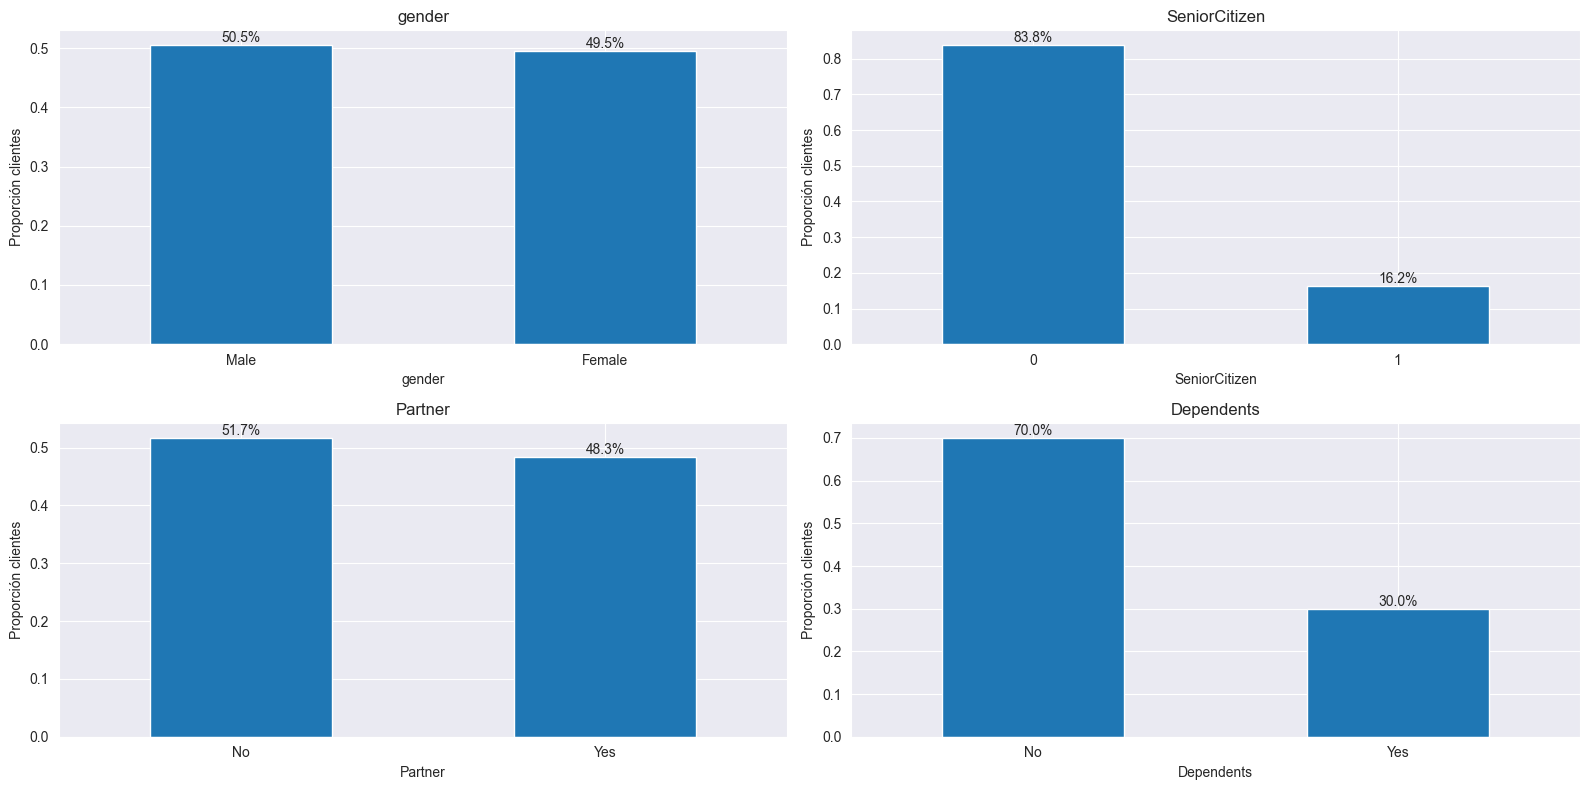

In [11]:
# Gráficos de barras para variables categóricas
fig, axes = plt.subplots(2, 2, figsize=(16, 8))  
axes = axes.flatten() 

for n, col in enumerate(['gender', 'SeniorCitizen', 'Partner', 'Dependents']):
    ax = axes[n]
    ax.set_ylabel('Proporción clientes')
    counts = personal[col].value_counts(normalize=True)
    bars = counts.plot(kind='bar', ax=ax, title=col, rot=0)
    
    # Etiquetas de porcentaje
    labels = [f'{100 * v:.1f}%' for v in counts]
    ax.bar_label(ax.containers[0], labels=labels)

plt.tight_layout()
plt.show()

Existe una proporción similar entre hombres y mujeres, con una ligera mayoría de hombres (50.5% frente a 49.5%). En cuanto a los clientes jubilados, representan menos del 20% del total. Por otro lado, el porcentaje de clientes sin pareja (51.7%) es ligeramente superior al de aquellos que sí tienen pareja (48.3%). Finalmente, el 70% de los clientes no tiene personas dependientes a su cargo.

**Acciones a seguir**

* Unificar el estilo de los títulos de las columnas usando *snake_case*.
* No es necesario imputar valores ausentes ni modificar el tipo de datos.

### Conjunto de datos `internet`

In [12]:
# Resumen básico del conjunto 'internet'
df_summary(internet)

Dimensiones: (5517, 8)

Información:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Número de valores duplicados: 0
Se ha encontrado a todos los usuarios: True



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


El dataset `internet` contiene 5,517 filas y 8 columnas, lo que indica que únicamente esos clientes utilizan los servicios de internet de Interconnect. Esto es importante tenerlo en cuenta al integrar toda la información en un solo conjunto de datos.

La información registrada incluye:

- `InternetService`: tipo de conexión, ya sea fibra óptica o DSL.
- `OnlineBackup`: almacenamiento de archivos en la nube y copia de seguridad de datos.
- `DeviceProtection`: uso de software de protección para dispositivos.
- `OnlineSecurity`: uso de bloqueo de sitios web maliciosos.
- `TechSupport`: acceso a una línea de soporte técnico.
- `StreamingTV`: servicio de streaming de televisión.
- `StreamingMovies`: servicio de streaming de películas.

No se detectaron valores ausentes ni duplicados, y los tipos de datos son correctos.

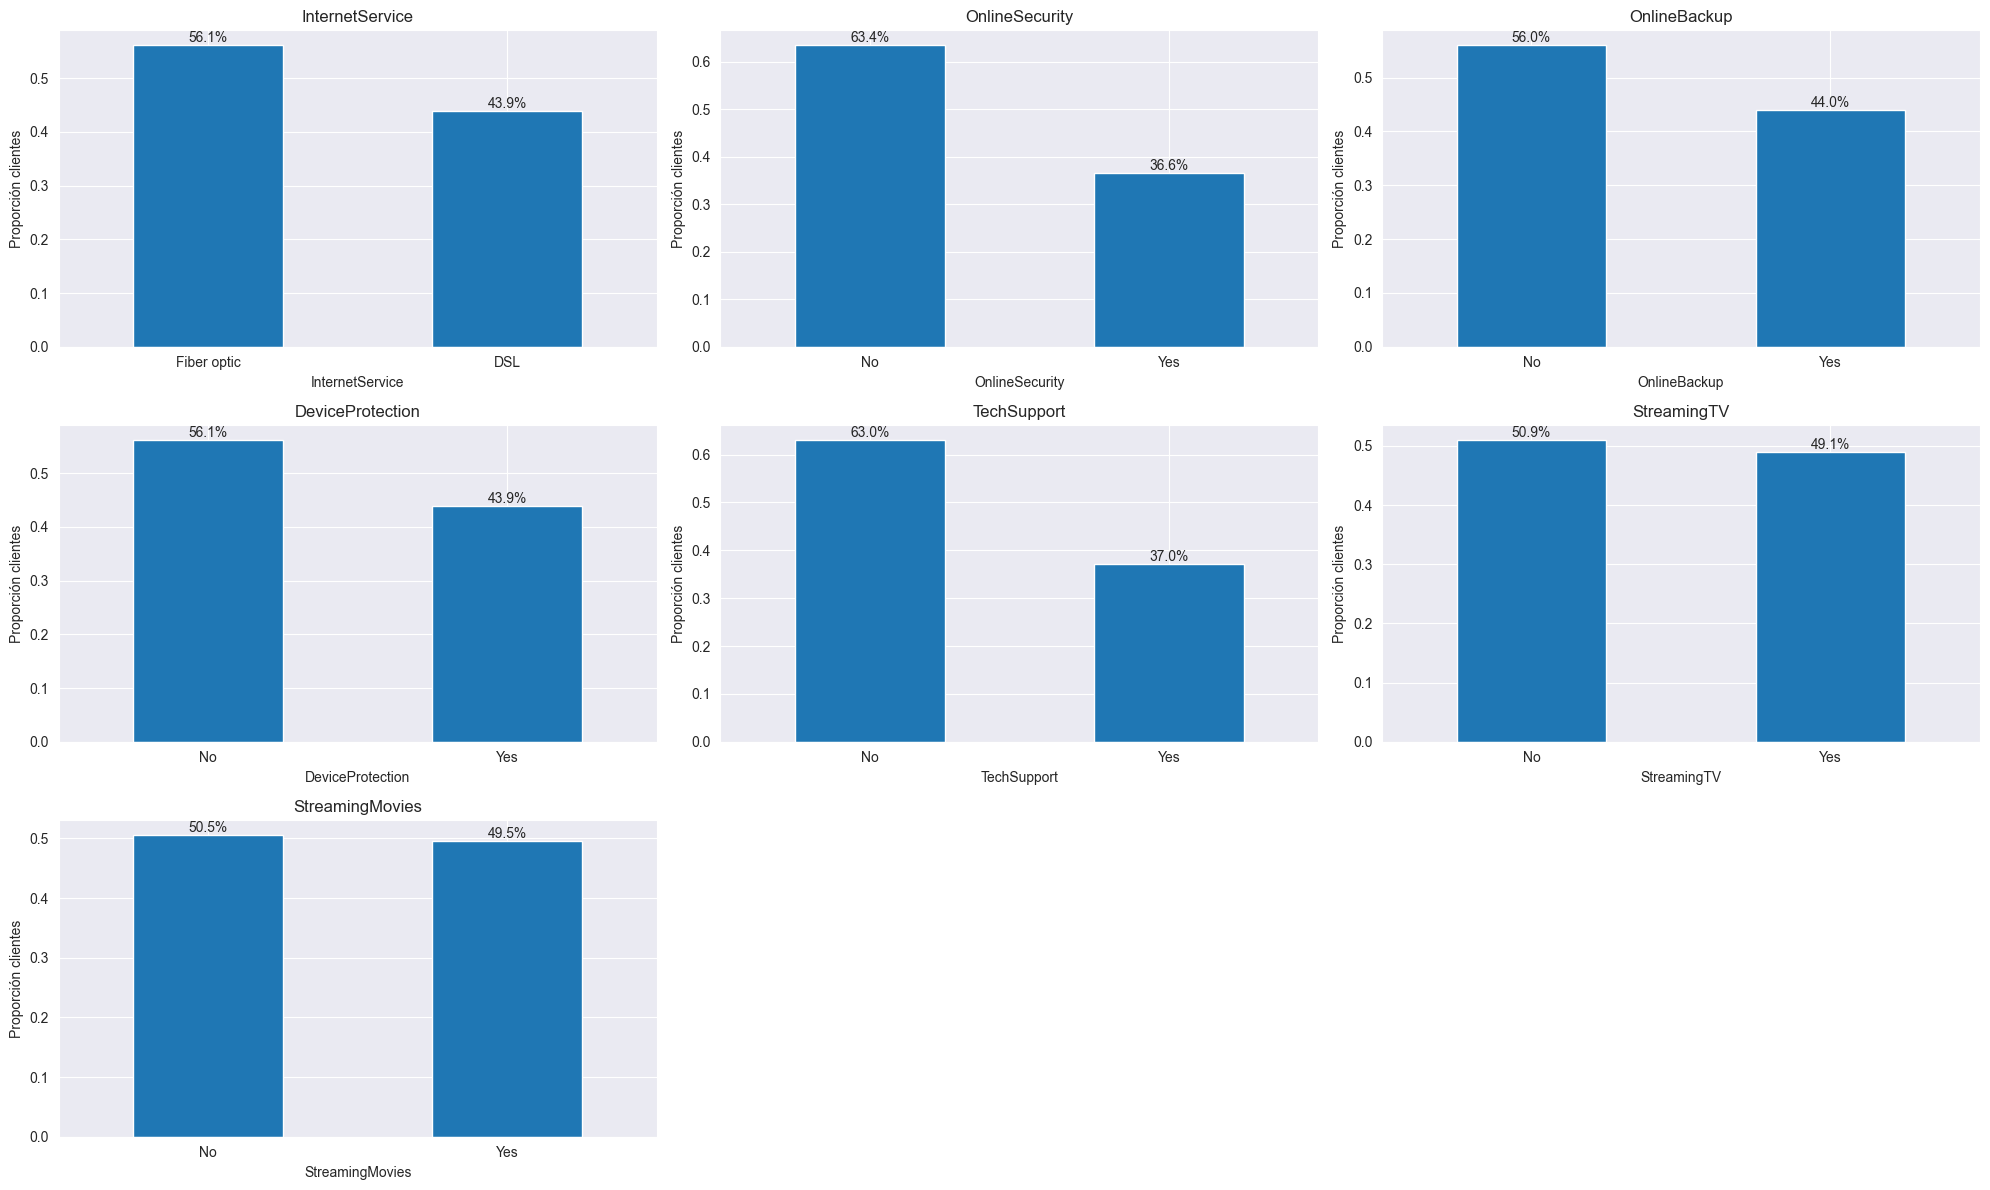

In [13]:
# Gráficos de barras para variables categóricas
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
axes = axes.flatten()

cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies']

for n, col in enumerate(cols):
    ax = axes[n]
    ax.set_ylabel('Proporción clientes')
    counts = internet[col].value_counts(normalize=True)
    bars = counts.plot(kind='bar', ax=ax, title=col, rot=0)
    
    # Etiquetas de porcentaje
    labels = [f'{100 * v:.1f}%' for v in counts]
    ax.bar_label(ax.containers[0], labels=labels)

# Eliminación de ejes sobrantes
for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

El 56.1% de los clientes prefieren contratar servicios de fibra óptica en lugar de DSL. En servicios como seguridad en línea, respaldo de datos, software antivirus y soporte técnico, se observa que entre el 56% y el 63% de los usuarios no hacen uso de ellos. Por ello, será necesario investigar más a fondo si estos factores pueden influir en la cancelación de cuentas por parte de los clientes.

En cuanto a los servicios de streaming de televisión y directorios de películas, la distribución es aproximadamente equitativa, con un 50% de usuarios que los utilizan y otro 50% que no.

**Acciones a seguir**

* Unificar el estilo de los títulos de las columnas usando *snake_case*.
* No es necesario imputar valores ausentes ni modificar el tipo de datos.
* Considerar que solo 5517 clientes contrataron los servicios de internet de la compañía.
* Analizar con mayor detalle si el uso o la ausencia de estos servicios influyen en la decisión de cancelar una cuenta.

### Conjunto de datos `phone`

In [14]:
# Resumen básico del conjunto 'phone'
df_summary(phone)

Dimensiones: (6361, 2)

Información:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Número de valores duplicados: 0
Se ha encontrado a todos los usuarios: True



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


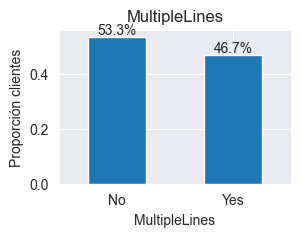

In [15]:
# Gráfico de barras para la variable categórica
counts = phone['MultipleLines'].value_counts(normalize=True)
ax = counts.plot(kind='bar', rot=0, title='MultipleLines', figsize=(3,2))
ax.set_ylabel('Proporción clientes')

# Etiquetas de porcentajes
labels = [f'{100 * v:.1f}%' for v in counts]
ax.bar_label(ax.containers[0], labels=labels)

plt.show()

El dataset phone contiene un total de 6,361 observaciones, lo que indica que solo esa cantidad de clientes utiliza los servicios de telefonía fija. De estos usuarios, un poco más de la mitad (53.3%) no contratan la conexión de múltiples líneas de forma simultánea.

No se registran valores faltantes ni datos duplicados, y los tipos de datos son los adecuados.

**Acciones a seguir**

* Unificar el estilo de los títulos de las columnas usando snake_case.
* No es necesario imputar valores ausentes ni modificar el tipo de datos.
* Considerar que solo 6,361 clientes contrataron los servicios de telefonía de la compañía.
* Analizar con mayor detalle si el uso o la ausencia de estos servicios influyen en la decisión de cancelar una cuenta.

## Observaciones

* Se importaron cuatro bases de datos que contienen información personal, planes y contratos de los clientes de Interconnect. En total, se cuenta con datos de 7,043 clientes, de los cuales 5,517 contrataron el servicio de internet y 6,361 adquirieron el plan de telefonía fija. Será necesario unificar toda esta información en un solo dataset.

* En el conjunto `contract`, será necesario transformar las columnas `BeginDate` y `EndDate` al tipo de dato *datetime* (`YYYY-MM-DD`). Además, se debe reemplazar las fechas de las cuentas no suspendidas por una fecha fija, tomando como referencia la fecha máxima registrada en `BeginDate`, 2020-02-01.

* El objetivo para la construcción de los modelos predictivos se definirá a partir de la columna `EndDate`, que indica la fecha de finalización del contrato. Para ello, se creará una nueva variable categórica con dos categorías: 0 para contratos no cancelados y 1 para contratos cancelados.

* En los datasets `personal`, `internet` y `phone` no se encontraron valores faltantes ni registros duplicados, y los tipos de datos están correctamente asignados.

* Será necesario modificar los nombres de las columnas de todos los conjuntos para que sigan las normas de buenas prácticas en programación.

# Preprocesamiento de datos

Con base en el análisis exploratorio inicial, se consolidará un único conjunto de datos que integre la información proveniente de los cuatro datasets originales. Este nuevo dataset incluirá juntas las variables de datos personales, tipo de contrato, servicio de internet y comunicación por teléfono fijo, abarcando al total de 7,043 usuarios de Interconnect.

In [16]:
# Combinación de los cuatro datasets en un nuevo dataframe
df = (contract.merge(personal, how='left', on='customerID')
      .merge(internet, how='left', on='customerID')
      .merge(phone, how='left', on='customerID')
     )

# Comprobación y visualización del nuevo dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Las columnas del nuevo conjunto de datos serán renombradas utilizando el estilo *snake_case*, conforme a las buenas prácticas recomendadas para facilitar la legibilidad y uniformidad en el manejo de variables.

In [17]:
#Enlistado de las columnas contenidas en el dataset
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

In [18]:
# Renombrado de columnas utilizando expresiones regulares para convertir nombres a snake_case
df.columns = df.columns.str.replace(r'(.)([A-Z][a-z]+)', r'\1_\2', regex=True) \
                       .str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True) \
                       .str.lower()

# Comprobación de los cambios
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

Se realizará la conversión del tipo de dato de la columna `begin_date` para ajustarla a su formato adecuado.

In [19]:
# Conversión de columna 'begin_date' a tipo datetime
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
print("Tipo de dato 'begin_date':", df['begin_date'].dtype)

Tipo de dato 'begin_date': datetime64[ns]


Se generará una nueva variable categórica que refleje si un cliente ha cancelado su cuenta o no.

In [20]:
# Creación de la variable objetivo 'exited' 
df['exited'] = df['end_date'].where(df['end_date'] != 'No', 0)
df['exited'] = df['exited'].where(df['end_date'] == 'No', 1)

# Conversión del tipo de dato de 'exited' a booleano
df['exited'] = df['exited'].astype('bool')

# Verificación de la distribución de valores en 'exited'
df['exited'].value_counts(dropna=False)

exited
False    5174
True     1869
Name: count, dtype: int64

En la columna `end_date`, los valores `“No”` serán reemplazados por una fecha específica (01-02-2020) y luego se convertirá esta columna al tipo datetime con formato YYYY-MM-DD. Esta variable se utilizará para definir el objetivo en los modelos de predicción posteriores.

In [21]:
# Reemplazo de valores específicos en la columna 'end_date'
df['end_date'] = df['end_date'].replace('No', pd.Timestamp('2020-02-01'))

# Conversión de la columna 'end_date' a formato datetime con manejo de errores
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
print('Tipo de dato end_date:', df['end_date'].dtype)

Tipo de dato end_date: datetime64[ns]


Para manejar los valores ausentes, se reemplazarán los datos faltantes en la columna `'total_charges'` utilizando los valores correspondientes en `'monthly_charges'`. A continuación, se crearán dos columnas binarias que indicarán la presencia o ausencia de servicio de internet y servicio telefónico, transformando estas variables en valores booleanos. Finalmente, los valores ausentes en las columnas categóricas restantes serán completados con la etiqueta "No", bajo el supuesto de que si el servicio básico no está activo, los servicios adicionales tampoco estarán presentes.

In [22]:
# Rellenado de NaN en total_charges
df['total_charges'] = df['total_charges'].fillna(df['monthly_charges'])

In [23]:
# Creación de columnas de servicio de internet
df['internet'] = df['internet_service'].notna().astype(int)
df['internet'] = df['internet'].astype('bool')

# Creación de columnas de servicio telefónico
df['phone'] = df['multiple_lines'].notna().astype(int)
df['phone'] = df['phone'].astype('bool')

In [24]:
# Rellenado de NaN en columnas restantes
nan_columns = df[['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
              'streaming_movies', 'multiple_lines', 'internet_service']]

for col in nan_columns:
    df[col] = df[col].fillna('No')

# Comprobamos que los ausentes hayan sido correctamente rellenados
print("Número de columnas con valores NaN:", df.isnull().any().sum())

Número de columnas con valores NaN: 0


In [25]:
# Ejemplo de columnas que tenían NaN y ahora están rellenas
df[df['begin_date'] == '2020-02-01'].head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,internet,phone
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,...,Yes,No,Yes,Yes,Yes,No,No,False,True,False
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,20.25,Male,0,...,No,No,No,No,No,No,No,False,False,True
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,80.85,Female,0,...,Yes,Yes,Yes,No,Yes,Yes,No,False,True,True


Para finalizar, se incorporará una nueva columna que registre el número de meses completos con el servicio activo. Esta información facilitará el análisis de la relación entre el total pagado y el gasto mensual del cliente.

In [26]:
# Cálculo de años y meses transcurridos
df['years'] = df['end_date'].dt.year - df['begin_date'].dt.year
df['months'] = (df['end_date'].dt.year - df['begin_date'].dt.year) * 12 + (df['end_date'].dt.month - df['begin_date'].dt.month)

## Observaciones

* Se unificaron los cuatro datasets originales en un único conjunto con 7,043 usuarios, integrando variables de datos personales, contrato, servicios de internet y teléfono fijo.

* Se aplicaron las buenas prácticas en la limpieza y preparación, incluyendo renombrado de columnas en *snake_case*, conversión de fechas y creación de variables categóricas para cancelar cuentas.

* En la columna `'end_date'`, los valores “No” se reemplazaron por la fecha 2020-02-01 y se transformaron a tipo datetime para definir el objetivo de predicción.

* Se llenaron los valores ausentes en cargos totales con datos de cargos mensuales y se convirtieron las variables de servicios en indicadores binarios, completando faltantes en categóricas con la etiqueta "No".

* Se añadió una columna con el número de meses completos de servicio para facilitar el análisis del gasto total en relación con el pago mensual.

# Análisis exploratorio de datos

En esta sección se presenta una visualización de las tasas de cancelación en las diferentes categorías del conjunto de datos. Posteriormente, se analizará la correlación entre las variables categóricas y numéricas con la variable objetivo 'exited'.

## Visualización de tasa de cancelación por subgrupos

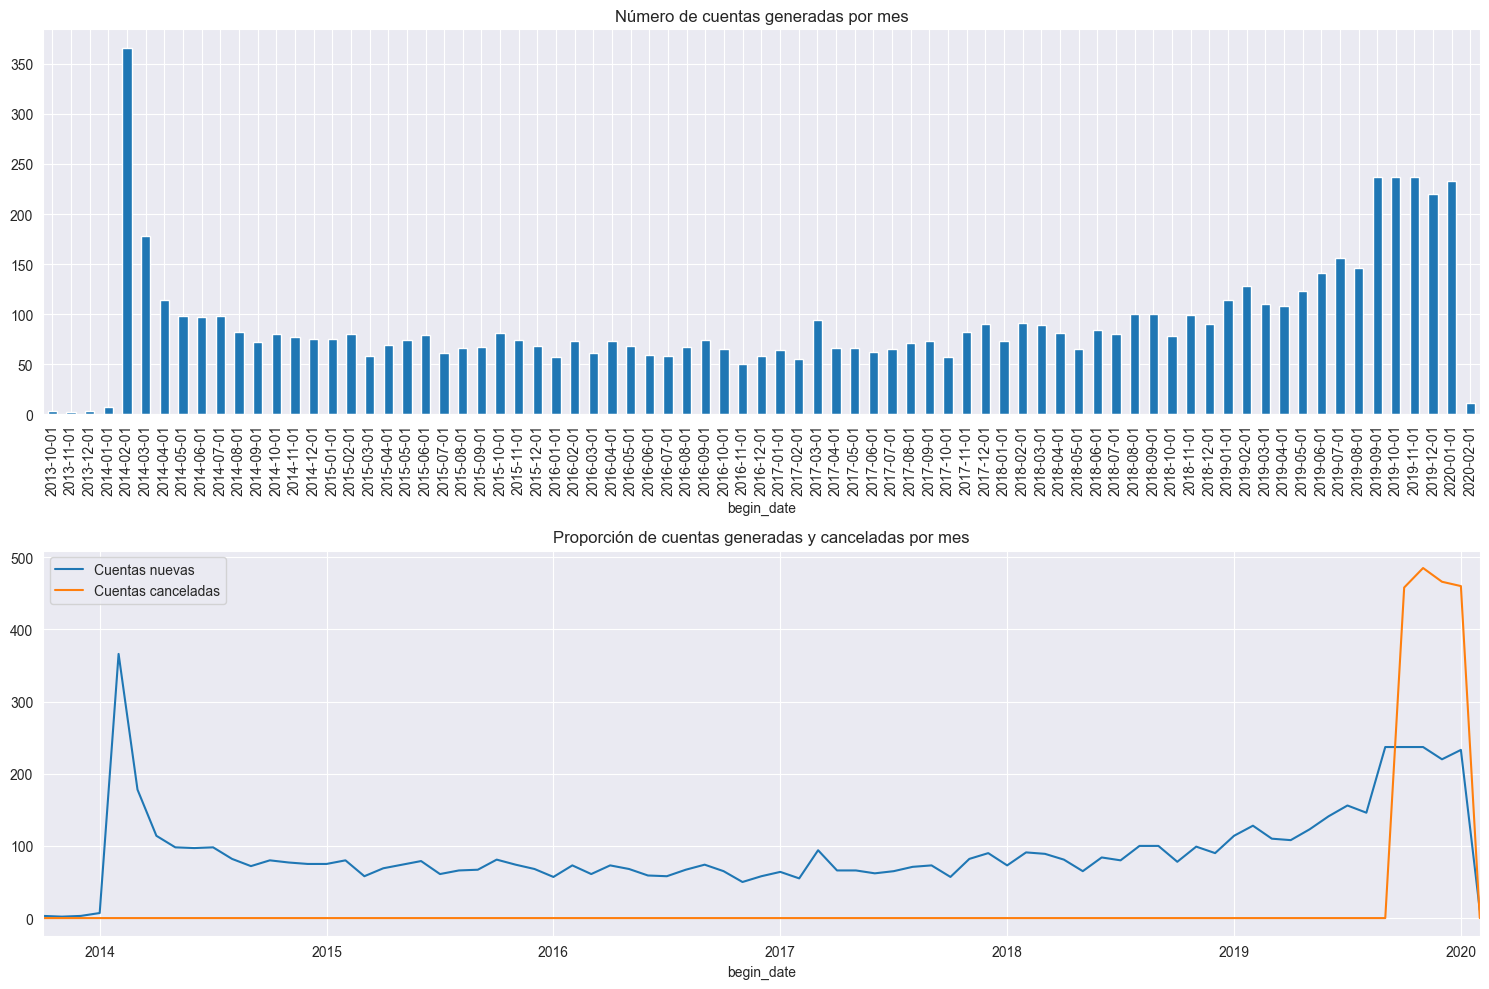

In [27]:
# Creación de figura y subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico de barras: cuentas generadas por mes
ax = axs[0]
begin_date_grouped = df.groupby('begin_date')['customer_id'].count()
begin_date_grouped.plot(kind='bar', ax=ax, title='Número de cuentas generadas por mes')
ax.set_xticklabels([x.strftime("%Y-%m-%d") for x in begin_date_grouped.index], rotation=90)

# Gráfico de líneas: cuentas generadas versus cuentas canceladas por mes
ax = axs[1]
filtered = df.query('exited == 1').groupby('end_date')['exited'].count()
filtered = filtered.reindex(index=begin_date_grouped.index).fillna(0)

begin_date_grouped.plot(ax=ax)
filtered.plot(ax=ax, title='Proporción de cuentas generadas y canceladas por mes')
plt.legend(['Cuentas nuevas', 'Cuentas canceladas'])

fig.tight_layout()

* En la evolución mensual en la captación de clientes a lo largo del tiempo, destaca un pico inicial muy marcado al inicio del periodo, seguido por una estabilización en la cantidad de cuentas nuevas, con fluctuaciones moderadas. A partir de 2019, hay una tendencia creciente en la generación de nuevas cuentas, indicando un aumento sostenido en la adquisición de clientes hacia el final del periodo analizado.

* El segundo gráfico compara la cantidad mensual de cuentas nuevas versus cuentas canceladas. Inicialmente, las cuentas nuevas superan ampliamente a las canceladas, pero a partir de finales de 2019, las cancelaciones experimentan un notable incremento, incluso superando en algunos meses a las nuevas cuentas. Esto evidencia un cambio en la dinámica del negocio, donde la retención de clientes se vuelve un desafío más grande a pesar del crecimiento en la captación.

* Resulta llamativa la ausencia de cancelaciones registradas durante cinco años, lo que sugiere posibles fallas en los datos. Podría tratarse de errores o retrasos en la recolección o procesamiento de la información sobre cancelaciones antes de esa fecha. También es posible que, antes de finales de 2019, las cancelaciones no se consideraran o etiquetaran formalmente, o se gestionaran de otra manera (por ejemplo, como suspensiones temporales o migraciones a otros productos sin cancelación formal de la cuenta). **En cualquier caso, esta aparente falta de cancelaciones debe ser investigada a partir del contexto del negocio y los procesos de gestión de datos para descartar errores o sesgos. Sin dicha revisión, cualquier análisis posterior basado en estos datos podría ser incompleto o engañoso.**

### Función de visualización

Se ha diseñado una función para visualizar las tasas de cancelación agrupadas por distintas categorías en el conjunto de datos. Para cada categoría, creará un gráfico de barras que mostrará la proporción de clientes que han cancelado frente a los que continúan, incluyendo anotaciones con los porcentajes correspondientes.

In [28]:
# Función para visualizar tasas de cancelación
def cancellation_rate(df, columns, text):

    # Configuración de la figura para el gráfico con tamaño personalizado
    fig = plt.figure(figsize=(18, 14))

    # Bucle para crear subplots para cada categoría
    for n, col in enumerate(columns):
        ax = plt.subplot(3, 3, n + 1)

        # Agrupación de datos por categoría y estado de 'exited' para conteos
        grouped = df.groupby([col, 'exited']).size().reset_index(name='count')
        grouped['total'] = grouped.groupby(col)['count'].transform('sum')
        grouped['proportion'] = grouped['count'] / grouped['total']

        # Creación de un gráfico de barras
        sns.barplot(data=grouped, x=col, y='proportion', hue='exited', ax=ax)

        # Configuración de etiquetas y título de cada subplot
        ax.set_ylabel('Proporción clientes')
        ax.set_title(col)
        plt.xticks(rotation=15)
        ax.set_xlabel('')

        # Anotación de cada barra con el porcentaje correspondiente
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(f"{height*100:.1f}%",
                            (p.get_x() + p.get_width() / 2, height),
                            ha='center', va='bottom',
                            fontsize=9, color='black',
                            xytext=(0, 3), textcoords='offset points')

    # Título general para toda la figura y ajuste del espacio superior
    fig.suptitle(f'Tasa de cancelación por {text}', fontsize=16)
    fig.subplots_adjust(top=0.95)
    plt.show()

### Tasa de cancelación por tipo de pago

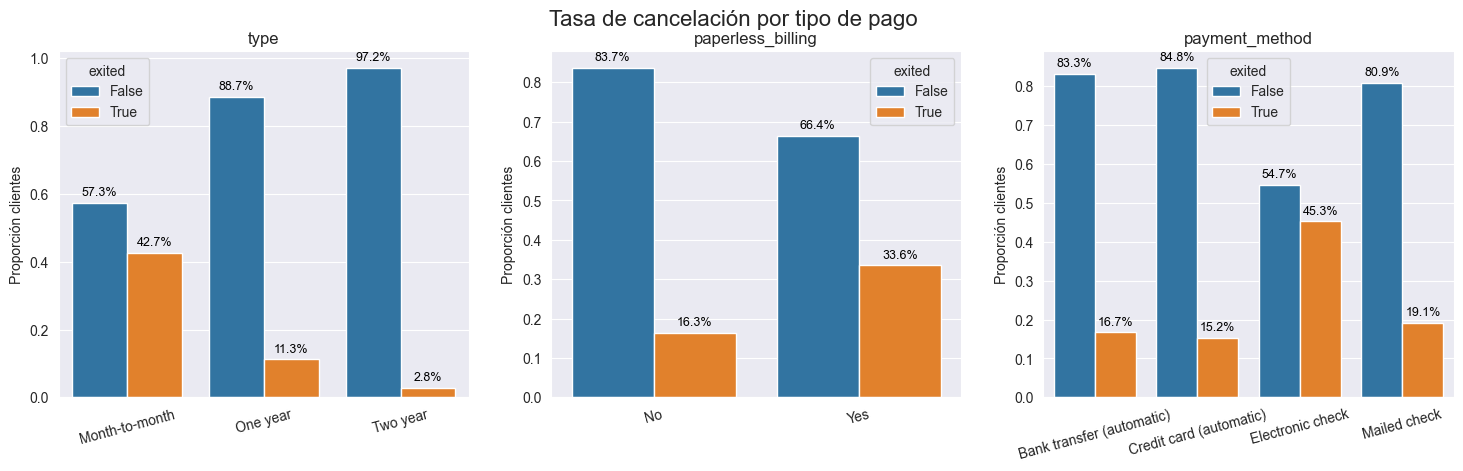

In [29]:
# Visualización de tasa de cancelación por tipo de pago
columns = ['type', 'paperless_billing', 'payment_method']
cancellation_rate(df, columns, 'tipo de pago')

* La tasa de cancelación es significativamente más alta entre los clientes con contrato mes a mes (el tipo de contrato predominante, con un 55.0% del total), alcanzando el 42.7%. En contraste, los contratos de dos años presentan una tasa muy baja de cancelación del 2.8%, mientras que los contratos anuales tienen una tasa intermedia del 11.3%. Esto sugiere que un mayor compromiso temporal está asociado con una mayor retención.

* Aunque un 59.2% de los clientes utilizan paperless billing, la tasa de cancelación en este grupo es considerablemente mayor (33.6%) en comparación con quienes no usan este servicio (16.3%). Esta diferencia puede indicar que, si bien la facturación sin papel mejora la eficiencia operativa, también podría estar asociada a un menor compromiso por parte del cliente o a una mayor propensión a cancelar.

* En cuanto a los métodos de pago, la cheques electrónicos —que constituyen el 33.6% del total— registran la tasa de cancelación más alta, con un 45.3%, muy por encima de tarjetas de crédito (15.2%) y transferencias bancarias (16.7%). Los cheques enviados por correo también evidencian una tasa relativamente elevada del 19.1%.

### Tasa de cancelación por grupo demográfico


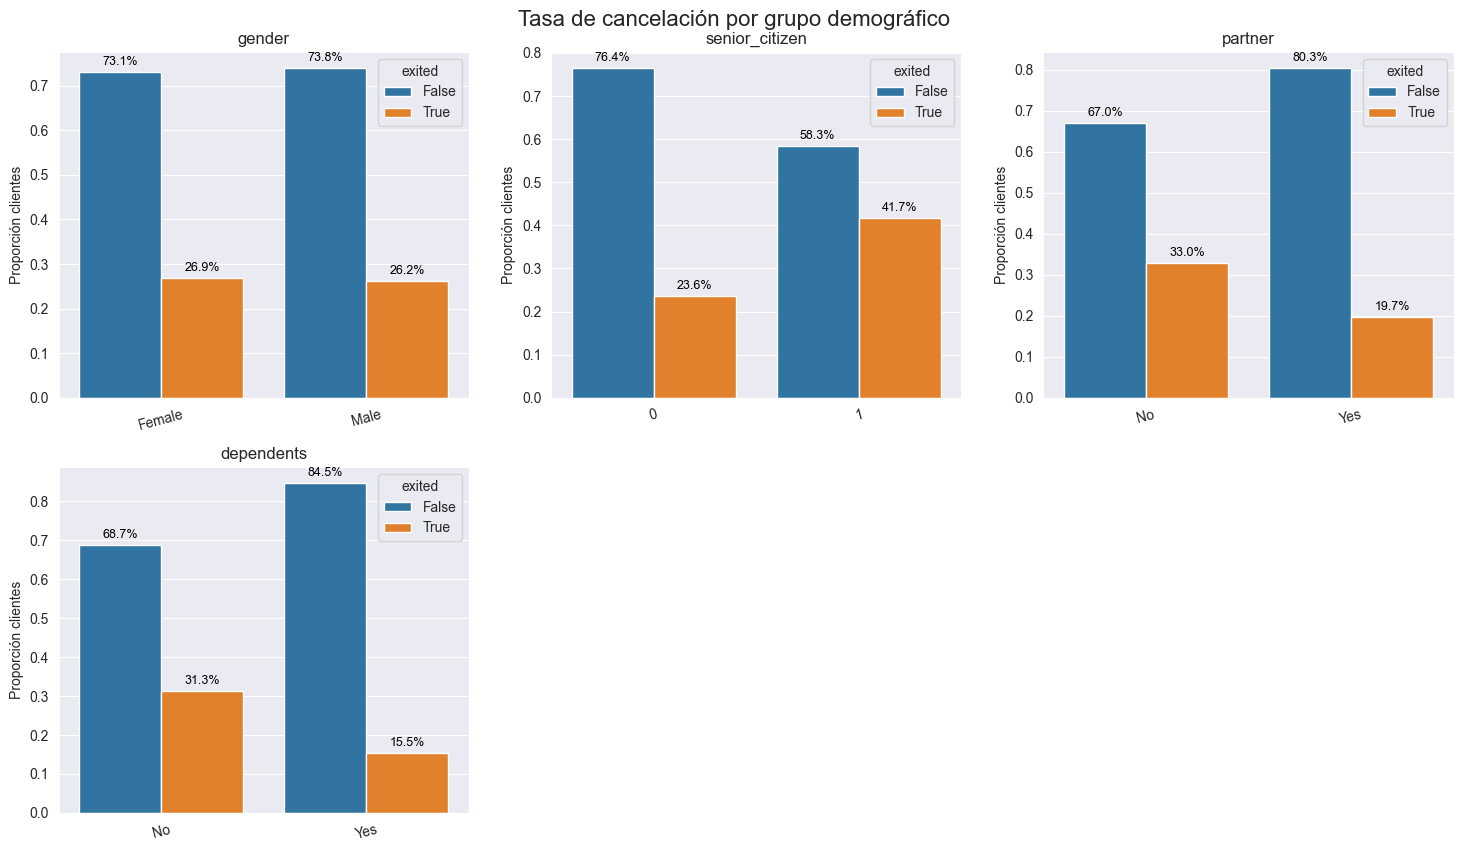

In [30]:
# Visualización de tasa de cancelación por grupo demográfico
columns = ['gender', 'senior_citizen', 'partner', 'dependents']
cancellation_rate(df, columns, 'grupo demográfico')

* Por género, las tasas son similares, con un 26.9% de cancelación en mujeres y 26.2% en hombres, mostrando estabilidad comparable.

* La categoría de adultos mayores (total de 16.2%) presenta una tasa de cancelación mucho más alta (41.7%) frente al 23.6% en adultos no mayores, lo que sugiere que esta población podría enfrentar barreras o insatisfacciones específicas que afectan su retención.

* Los clientes con pareja tienen una tasa menor de cancelación (19.7%) en comparación con quienes no la tienen (33.0%).

* Los clientes con dependientes muestran una tasa de cancelación baja (15.5%) frente a aquellos sin dependientes (31.3%), lo que podría indicar un compromiso mayor o valor percibido diferente en estos grupos.

### Tasa de cancelación por tipo de servicio

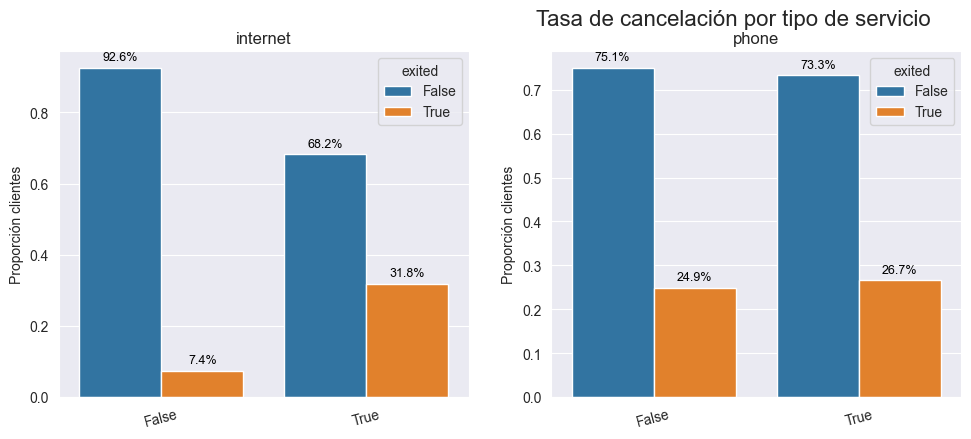

In [31]:
# Visualización de tasa de cancelación por tipo de servicio
columns = ['internet', 'phone']
cancellation_rate(df, columns, 'tipo de servicio')

* En la categoría de internet, que comprende al 78.3% del total de clientes, la tasa de cancelación es elevada, alcanzando el 31.8%, mientras que el grupo sin este servicio (22.7% del total) mantiene una tasa baja del 7.4%. Esto indica que los clientes con internet tienen una mayor propensión a cancelar, posiblemente por factores como la insatisfacción con la calidad o el costo del servicio.

* En contraste, la categoría de teléfono abarca la mayoría del total de clientes (90.3%), cuya tasa de cancelación es moderada, en torno al 26.7%, comparada con un 24.9% en quienes no lo tienen (9.7% del total). La estabilidad relativa mayor en clientes con teléfono puede estar asociada con una menor sensibilidad al precio o mayor dependencia del servicio.

### Tasa de cancelación por servicio extra

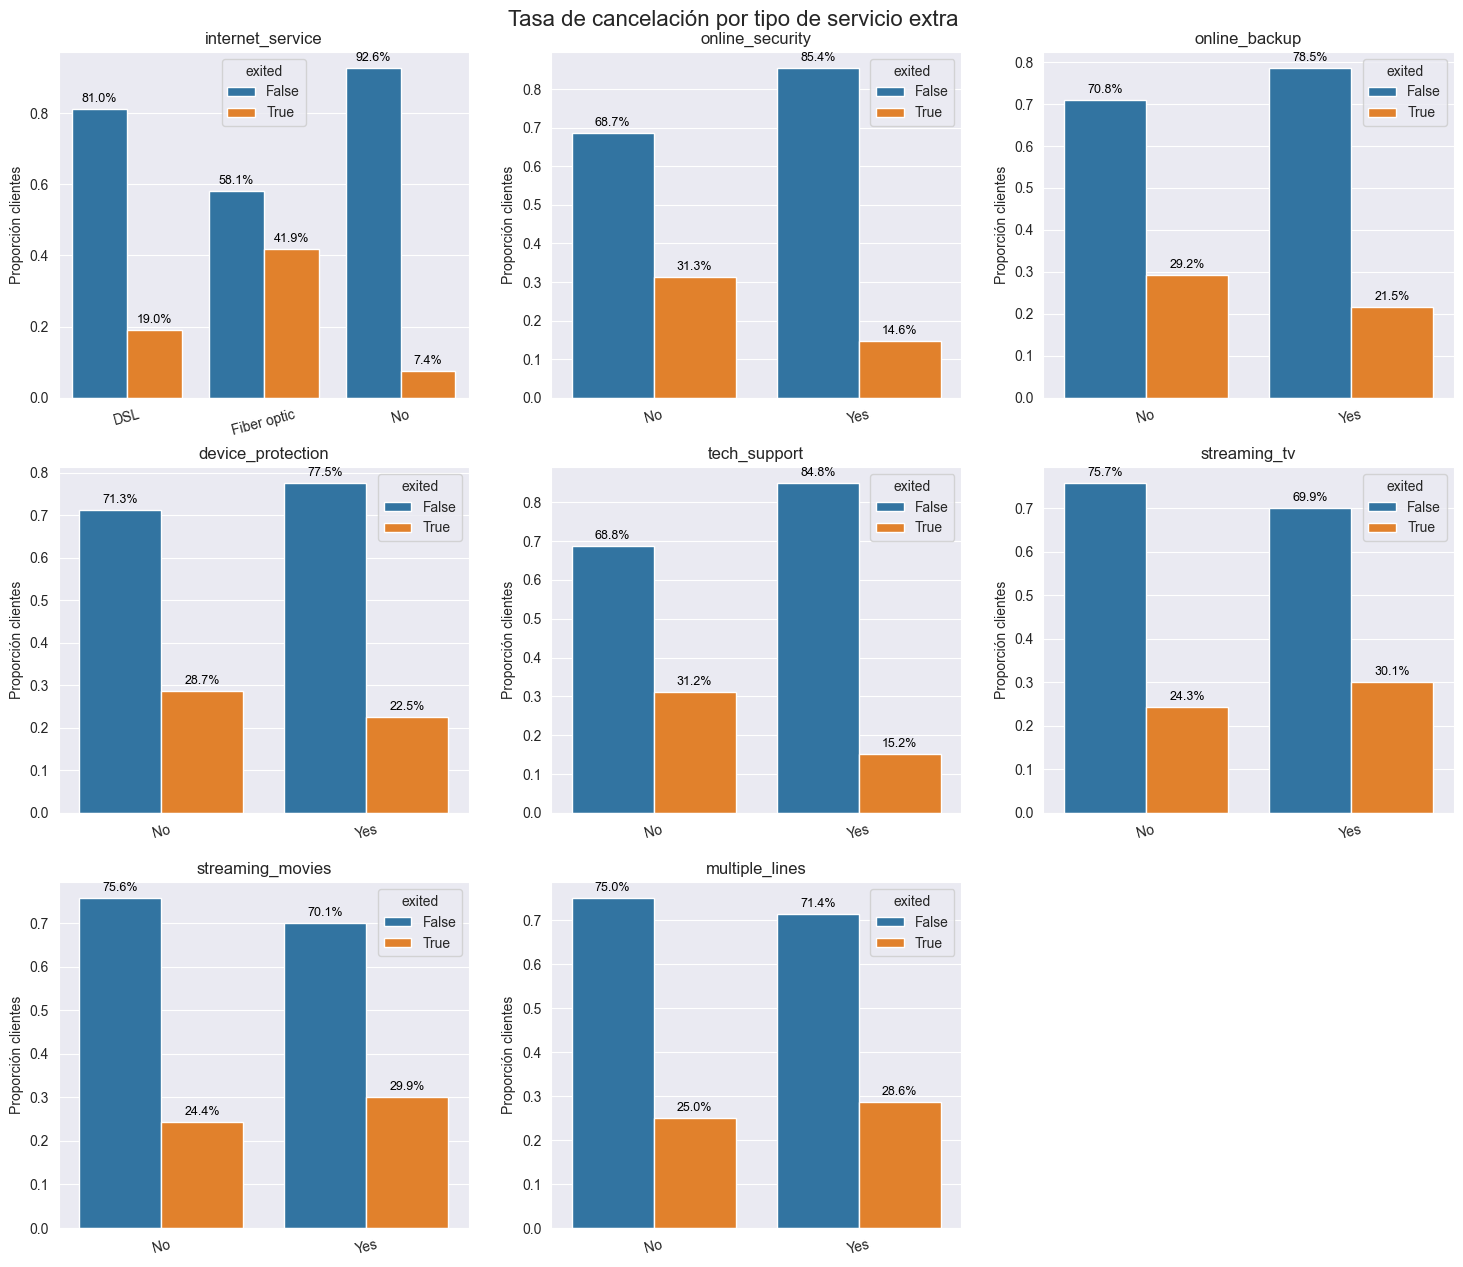

In [32]:
# Visualización de tasa de cancelación por tipo de servicio extra
filtered_phone = df.loc[df['phone'] == 1, ['multiple_lines']]
columns = ['internet_service', 'online_security', 'online_backup', 'device_protection',
           'tech_support', 'streaming_tv', 'streaming_movies']
filtered_internet = df.loc[df['phone'] == 1, columns]

# Concatenar columnas definidas
filtered_combined = pd.concat([filtered_internet, filtered_phone], axis=1)

cancellation_rate(df, filtered_combined, 'tipo de servicio extra')

* En cuanto al tipo de internet, aunque el 56.1% de los clientes utiliza DSL, su tasa de cancelación es relativamente baja, del 19%, mientras que la fibra óptica, con un 43.9% de clientes, muestra una tasa más alta de cancelación del 41.9%. Esto podría indicar que algunos usuarios de fibra óptica enfrentan expectativas no satisfechas o costos asociados más elevados, lo que impacta en su permanencia.

* En servicios de seguridad en línea, los clientes sin este servicio (63.4% del total) presentan una tasa de cancelación del 31.3%, bastante mayor que la de quienes sí cuentan con seguridad en línea (14.6%), sugiriendo que incluir esta prestación puede mejorar la retención.

* Comportamientos similares se observan en online backup y protección de dispositivos: quienes disponen de estos servicios tienen tasas de cancelación inferiores (21.5% y 22.5%, respectivamente) frente a quienes no los tienen (29.2% y 28.7%).

* En soporte técnico, la diferencia es aún más marcada, con un 31.2% de cancelación en clientes sin soporte, versus sólo 15.2% con soporte técnico, lo que indica una influencia positiva decisiva de este servicio en la retención.

* Para servicios de streaming, tanto TV como películas, los clientes que los contratan muestran tasas de cancelación más elevadas (aproximadamente 30%) que quienes no los tienen (alrededor de 24%), fenómeno que podría relacionarse con costos adicionales o con expectativas que no se cumplen completamente.

* En la opción de líneas múltiples, curiosamente, la tasa de cancelación es menor sin líneas múltiples (25%) en comparación con clientes que sí tienen varias líneas (28.6%).

### Tasa de cancelación por cargos

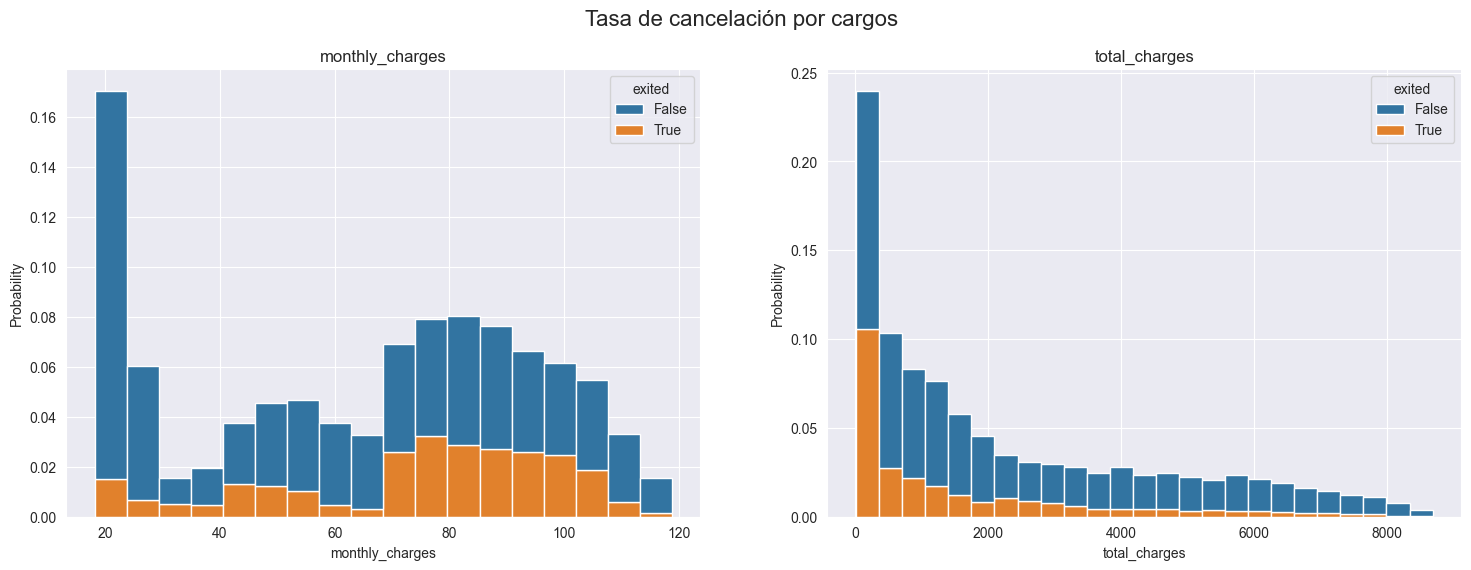

In [33]:
# Visualización de tasa de cancelación por cargos

# Configuración de la figura para el gráfico con tamaño personalizado
fig = plt.figure(figsize=(18, 12))

# Definición de paleta de colores para las categorías de cancelación
color_palette = {0: '#3274a1', 1: '#e1812c'}  # map exited classes to specific colors

# Creación de histogramas para analizar la tasa de cancelación
for n, col in enumerate(['monthly_charges', 'total_charges']):
    ax = plt.subplot(2, 2, n + 1)
    sns.histplot(df, x=col, hue='exited', stat='probability', multiple='stack',
                 palette=color_palette, ax=ax, alpha=1)
    ax.set_title(col)

# Configuración final del título general y ajuste de espacios del gráfico
fig.suptitle('Tasa de cancelación por cargos', fontsize=16)
fig.subplots_adjust(top=0.93)
plt.show()

* En el primer gráfico, se observa que la probabilidad de cancelación tiende a aumentar en clientes con cargos mensuales entre aproximadamente 70 y 100 dólares. Mientras que los clientes con cargos mensuales muy bajos (cercanos a 20) presentan una alta concentración, la proporción de cancelación es menor en este rango comparado con los montos medios.

* En el segundo gráfico, que representa los cargos totales, la mayoría de los clientes que han cancelado se concentran en el rango bajo de cargos acumulados, indicando que muchos clientes abandonan el servicio poco después de iniciar su contrato. La probabilidad de cancelación disminuye conforme aumentan los cargos totales, lo que puede interpretarse como mayor fidelidad de clientes que han permanecido por períodos más largos, reflejándose en montos acumulados mayores.

### Tasa de cancelación por tiempo de servicio

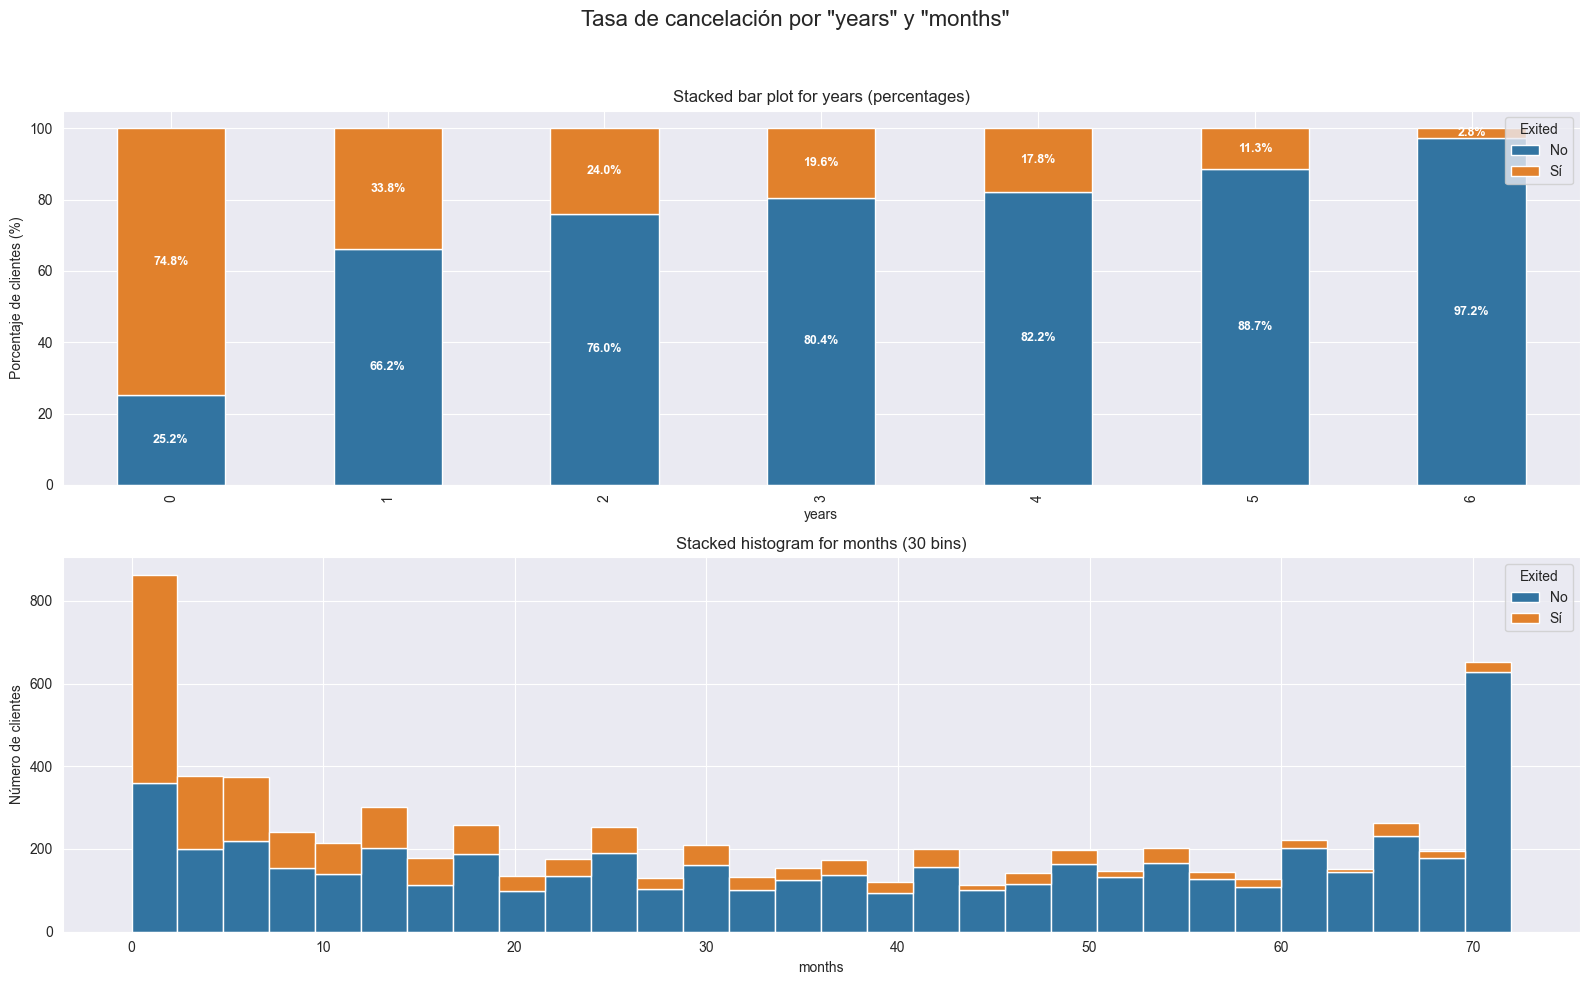

In [34]:
# Visualización de tasa de cancelación por tiempo de servicio

# Configuración de la figura para el gráfico con tamaño personalizado
fig = plt.figure(figsize=(16, 10))

# Agrupación y procesamiento de datos por años y estado de cancelación
ax1 = plt.subplot(2, 1, 1)
grouped_years = df.groupby(['years', 'exited']).size().unstack(fill_value=0)

# Cálculo de porcentajes para cada año
grouped_years_perc = grouped_years.div(grouped_years.sum(axis=1), axis=0) * 100

# Definición de colores para los estados 'Exited' (No, Sí)
colors = ['#3274a1', '#e1812c']

# Gráfico de barras apiladas mostrando porcentajes por año y estado de cancelación
grouped_years_perc.plot(kind='bar', stacked=True, ax=ax1, legend=False, color=colors)
ax1.set_title('Stacked bar plot for years (percentages)')
ax1.set_xlabel('years')
ax1.set_ylabel('Porcentaje de clientes (%)')

# Etiquetado con porcentaje dentro de cada segmento de barra apilada
for i, (year, row) in enumerate(grouped_years_perc.iterrows()):
    bottom = 0
    for j, perc in enumerate(row):
        if perc > 0:  # show label only if the portion is non-zero
            ax1.text(i, bottom + perc / 2, f'{perc:.1f}%', ha='center', va='center', color='white', fontsize=9, fontweight='bold')
        bottom += perc

ax1.legend(title='Exited', loc='upper right', labels=['No', 'Sí'], frameon=True)

# Gráfico de histograma apilado para meses, separado por estado de cancelación
ax2 = plt.subplot(2, 1, 2)
months_exited_0 = df.loc[df['exited'] == 0, 'months']
months_exited_1 = df.loc[df['exited'] == 1, 'months']

ax2.hist([months_exited_0, months_exited_1], bins=30, stacked=True, label=['No', 'Sí'], color=colors)
ax2.set_title('Stacked histogram for months (30 bins)')
ax2.set_xlabel('months')
ax2.set_ylabel('Número de clientes')
ax2.legend(title='Exited', loc='upper right')

# Configuración final del título general y ajuste de espacios del gráfico
fig.suptitle('Tasa de cancelación por "years" y "months"', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

* El análisis por años revela una clara tendencia a la disminución de la tasa de cancelación conforme aumenta la antigüedad del cliente. El 74.8% de los clientes que han cancelado sólo tenían un año, mientras que para clientes con seis años de permanencia la tasa de cancelación se reduce considerablemente a solo el 2.8%. Esto indica que la retención mejora significativamente después del primer año y se estabiliza a niveles muy bajos con el paso del tiempo.
  
* El histograma mensual muestra que la mayoría de los clientes que cancelan tienden a hacerlo en los primeros meses de la relación con el servicio, especialmente en el rango entre 0 y 10 meses. Además, se observa un aumento en la cantidad total de clientes que permanecen cerca del límite máximo de observación (alrededor de 70 meses), donde la proporción de cancelaciones es mínima, lo que refuerza la idea de que la fidelización se fortalece con el tiempo.

## Análisis de correlación entre variable objetivo y distintas categorías

En esta sección se analizará la correlación entre la variable objetivo `'exited'` y el resto de variables del conjunto de datos. Este análisis permitirá identificar cuáles factores tienen mayor influencia en la cancelación del servicio.

### Determinación de características categóricas y numéricas

A continuación, se clasifican las variables según su naturaleza.

In [35]:
# Determinación de características categóricas y numéricas 

cat_features = ['type', 'paperless_billing', 'payment_method', 
                'gender', 'senior_citizen', 'partner', 'dependents', 
                'internet_service', 'online_security', 'online_backup', 'device_protection', 
                'tech_support', 'streaming_tv', 'streaming_movies', 
                'multiple_lines', 
                'internet', 'phone']

num_features = ['monthly_charges', 'total_charges', 
                'years', 'months']

### Correlación con variables numéricas

Procederemos a realizar un análisis bivariado evaluando la correlación de Pearson entre variables numéricas, con el objetivo de identificar la fuerza y dirección de las relaciones lineales existentes. Este enfoque nos permitirá comprender cómo se asocian cuantitativamente las variables, facilitando la detección de patrones y posibles dependencias relevantes para el modelo y la interpretación del comportamiento de los clientes.

,exited,monthly_charges,total_charges,years,months
exited,1.000000,0.193356,-0.198347,-0.431905,-0.352229
monthly_charges,0.193356,1.000000,0.651182,0.215257,0.247900
total_charges,-0.198347,0.651182,1.000000,0.799366,0.826164
years,-0.431905,0.215257,0.799366,1.000000,0.981381
months,-0.352229,0.247900,0.826164,0.981381,1.000000


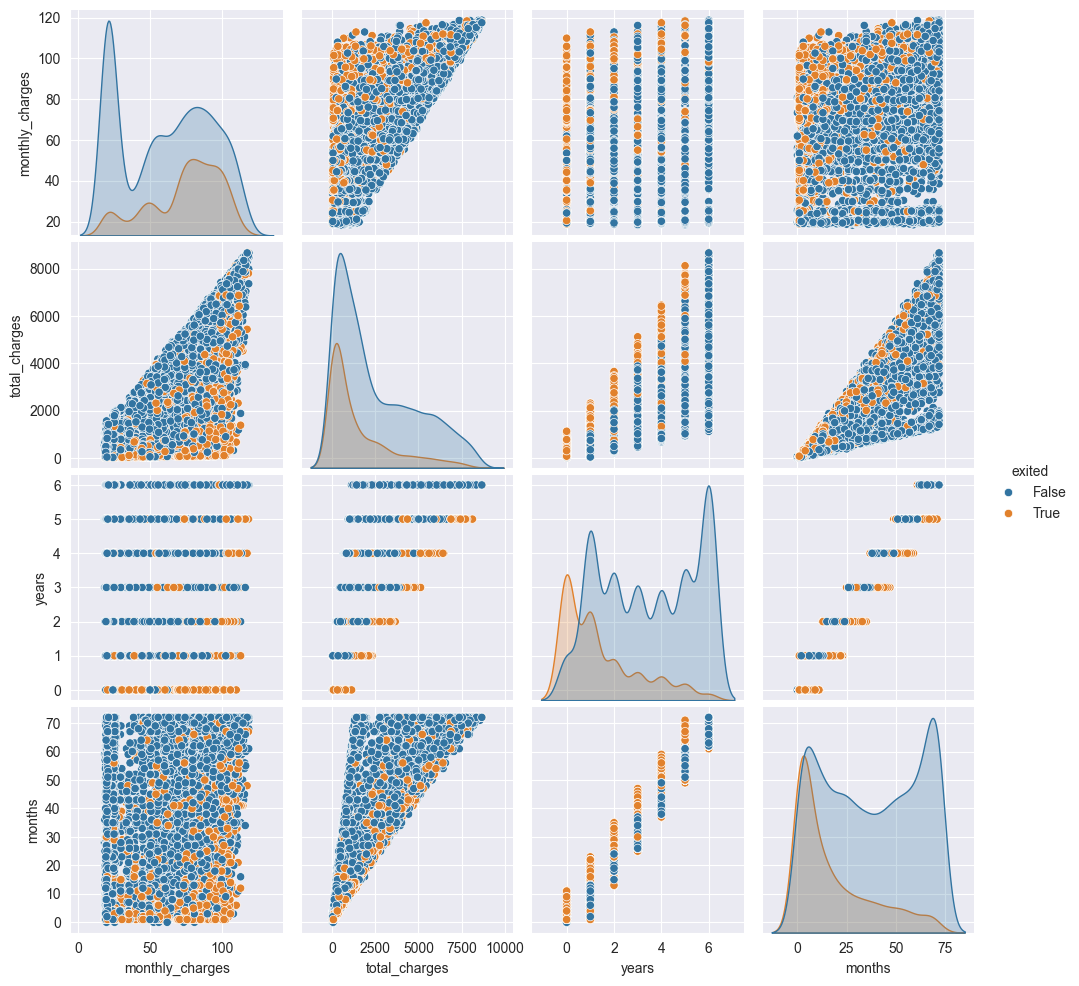

In [36]:
# Tabla de correlación entre 'exited' y categorías numéricas
display(df[['exited'] + num_features].corr())

# Visualización por pares: gráfico de dispersión y distribución
sns.pairplot(df[['exited'] + num_features], hue='exited', palette=color_palette)
plt.show()

* En la comparación entre `'monthly_charges'` y `'exited'`, se observa que los clientes que cancelaron (naranja) se concentran en un rango de cargos mensuales bajos a moderados, mientras que los clientes que permanecen (azul) presentan una distribución más amplia con picos marcados. La correlación positiva, aunque débil (0.193), sugiere que cargos mensuales ligeramente más altos pueden aumentar la probabilidad de cancelación, aunque su impacto es menor frente a otros factores como la antigüedad.

* La variable `'total_charges'` indica que quienes permanecen tienden a acumular mayores cargos totales, mientras que los que cancelan presentan montos más bajos, lo cual sugiere que la cancelación ocurre mayormente en las primeras etapas del contrato. La correlación negativa débil (-0.198) refuerza la idea de que un menor gasto acumulado se asocia con mayor riesgo de churn.

* Respecto a la antigüedad, las variables `'years'` y `'months'` muestran una diferencia significativa: los clientes que permanecen tienen una mayor concentración en periodos largos de servicio (4-6 años o valores elevados en meses), mientras que los que cancelan se agrupan en períodos cortos (0-2 años o meses bajos). Las correlaciones negativas moderadas (-0.432 para `'years'` y -0.352 para `'months'`) confirman que a mayor duración en el servicio, menor es la probabilidad de cancelación.

* Se identifica un patrón claro donde la antigüedad y el compromiso financiero están estrechamente relacionados con la permanencia: los clientes fieles suelen acumular tanto mayores cargos totales como más meses de servicio, mientras que quienes cancelan presentan valores más bajos en ambas variables.

### Correlación con variables categóricas

La estadística de Cramér's V es una medida que cuantifica la fuerza de asociación entre variables categóricas y un objetivo, otorgando un valor entre 0 (sin asociación) y 1 (asociación perfecta). Se basa en el estadístico chi-cuadrado de Pearson y normaliza su valor para evitar sesgos derivados del tamaño de la tabla de contingencia entre categorías.

In [37]:
# Función para calcular la estadística de Cramér's V entre dos variables categóricas
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Función para calcular Cramér's V entre múltiples variables categóricas y un objetivo
def cramers_v_multiple(df, cat_features, target):
    results = []
    for col in cat_features:
        cv = round(cramers_v(df[col], df[target]), 2)
        results.append({'feature': col, "cramers_v": cv})
    return pd.DataFrame(results)

# Tabla de resultados de la estadística de Cramér's V
cramers_v_multiple(df, cat_features, 'exited')

,feature,cramers_v
0,type,0.41
1,paperless_billing,0.19
2,payment_method,0.30
3,gender,0.00
4,senior_citizen,0.15
5,partner,0.15
6,dependents,0.16
7,internet_service,0.32
8,online_security,0.17
9,online_backup,0.08


Los resultados del estadístico de Cramér's V revelan que la variable categórica con mayor asociación con la cancelación del servicio (`'exited'`) es el tipo de contrato (`'type'`), con un valor significativo de 0.41, lo que indica una relación moderada. También destacan la modalidad de pago (`'payment_method'`) y el tipo de servicio de internet (`'internet_service'`), con valores de 0.30 y 0.32 respectivamente, sugiriendo que estas variables influyen en el comportamiento de abandono. Otras variables como la facturación sin papel (`'paperless_billing'`) y la presencia de internet como servicio (`'internet'`) muestran asociaciones leves, mientras que características demográficas como género o la posesión de teléfono presentan nulas o muy bajas correlaciones. En conjunto, estos resultados apuntan a que factores relacionados con el contrato y la modalidad de servicio son más relevantes para entender la cancelación que los atributos personales o servicios complementarios.

In [38]:
# Función para realizar test chi-cuadrado
def chi_square_test_multiple(df, cat_features, target):
    results = []
    for col in cat_features:
        contingency_table = pd.crosstab(df[col], df[target])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        significant = p < 0.05  # Use 5% significance threshold
        
        p_formatted = f"{p:.2e}"
        
        results.append({
            'feature': col,
            'chi2_statistic': round(chi2, 2),
            'p_value': p_formatted,
            'significant': significant
        })
    return pd.DataFrame(results)

# Tabla de resultados de chi-cuadrado
chi_square_test_multiple(df, cat_features, 'exited')

,feature,chi2_statistic,p_value,significant
0,type,1184.60,5.86e-258,True
1,paperless_billing,258.28,4.07e-58,True
2,payment_method,648.14,3.68e-140,True
3,gender,0.48,4.87e-01,False
4,senior_citizen,159.43,1.51e-36,True
5,partner,158.73,2.14e-36,True
6,dependents,189.13,4.92e-43,True
7,internet_service,732.31,9.57e-160,True
8,online_security,205.63,1.23e-46,True
9,online_backup,47.26,6.21e-12,True


Los resultados del estadístico chi-cuadrado y sus valores p complementan la estadística de Cramér's V al confirmar la significancia estadística de las asociaciones entre las variables categóricas y la variable objetivo `'exited'`. Mientras que Cramér's V mide la fuerza relativa de la asociación, el chi-cuadrado verifica si esta asociación es estadísticamente significativa, lo cual se observa en la mayoría de las variables analizadas con valores p extremadamente bajos y estadísticos chi-cuadrado elevados, excepto en casos como `'gender'` y `'phone'`, que no muestran asociación significativa. En general, variables relacionadas con el tipo de servicio, métodos de pago y la presencia de servicios adicionales presentan asociaciones fuertes y significativas con la cancelación del servicio, reforzando el análisis previo de correlación.

### Correlación punto-biserial múltiple

Para concluir, realizaremos un análisis de correlación punto-biserial múltiple, que mide la relación entre la variable binaria objetivo (`'exited'`) y varias variables continuas del dataset simultáneamente. Este método permite cuantificar la fuerza y dirección de la asociación entre el estado del cliente y diversos indicadores cuantitativos de manera efectiva.

In [39]:
# Función para calcular correlación punto-biserial múltiple  
def pointbiserialr_multiple(df, num_features, target):
    results = []
    for col in num_features:
        valid = df[[col, target]].dropna()
        corr, pval = pointbiserialr(valid[target], valid[col])
        significant = pval < 0.05  # Use 5% significance threshold
        
        p_formatted = f"{pval:.2e}"
        
        results.append({
            'feature': col,
            'pointbiserial_r': round(corr, 2),
            'p_value': p_formatted,
            'significant': significant
        })
    return pd.DataFrame(results)

# Tabla de resultados del análisis de correlación punto-biserial múltiple  
pointbiserialr_multiple(df, num_features, 'exited')

,feature,pointbiserial_r,p_value,significant
0,monthly_charges,0.19,2.71e-60,True
1,total_charges,-0.20,2.06e-63,True
2,years,-0.43,4.75e-318,True
3,months,-0.35,8.00e-205,True


El análisis de correlación punto-biserial revela asociaciones significativas entre la variable objetivo 'exited' y varias características clave. Como se observó anteriormente, se aprecia que la duración del cliente en años y meses presenta una correlación negativa moderada, indicando que a mayor tiempo de permanencia, menor probabilidad de cancelación. De manera similar, el total acumulado de cargos muestra una relación negativa, sugiriendo que clientes con menor gasto total tienden a abandonar el servicio más pronto. Por otro lado, los cargos mensuales mantienen una correlación positiva pero débil, lo que implica que tarifas mensuales más altas pueden aumentar ligeramente el riesgo de cancelación. Todos estos resultados son estadísticamente significativos, reforzando la importancia de la antigüedad y el comportamiento de pagos en la retención de clientes.

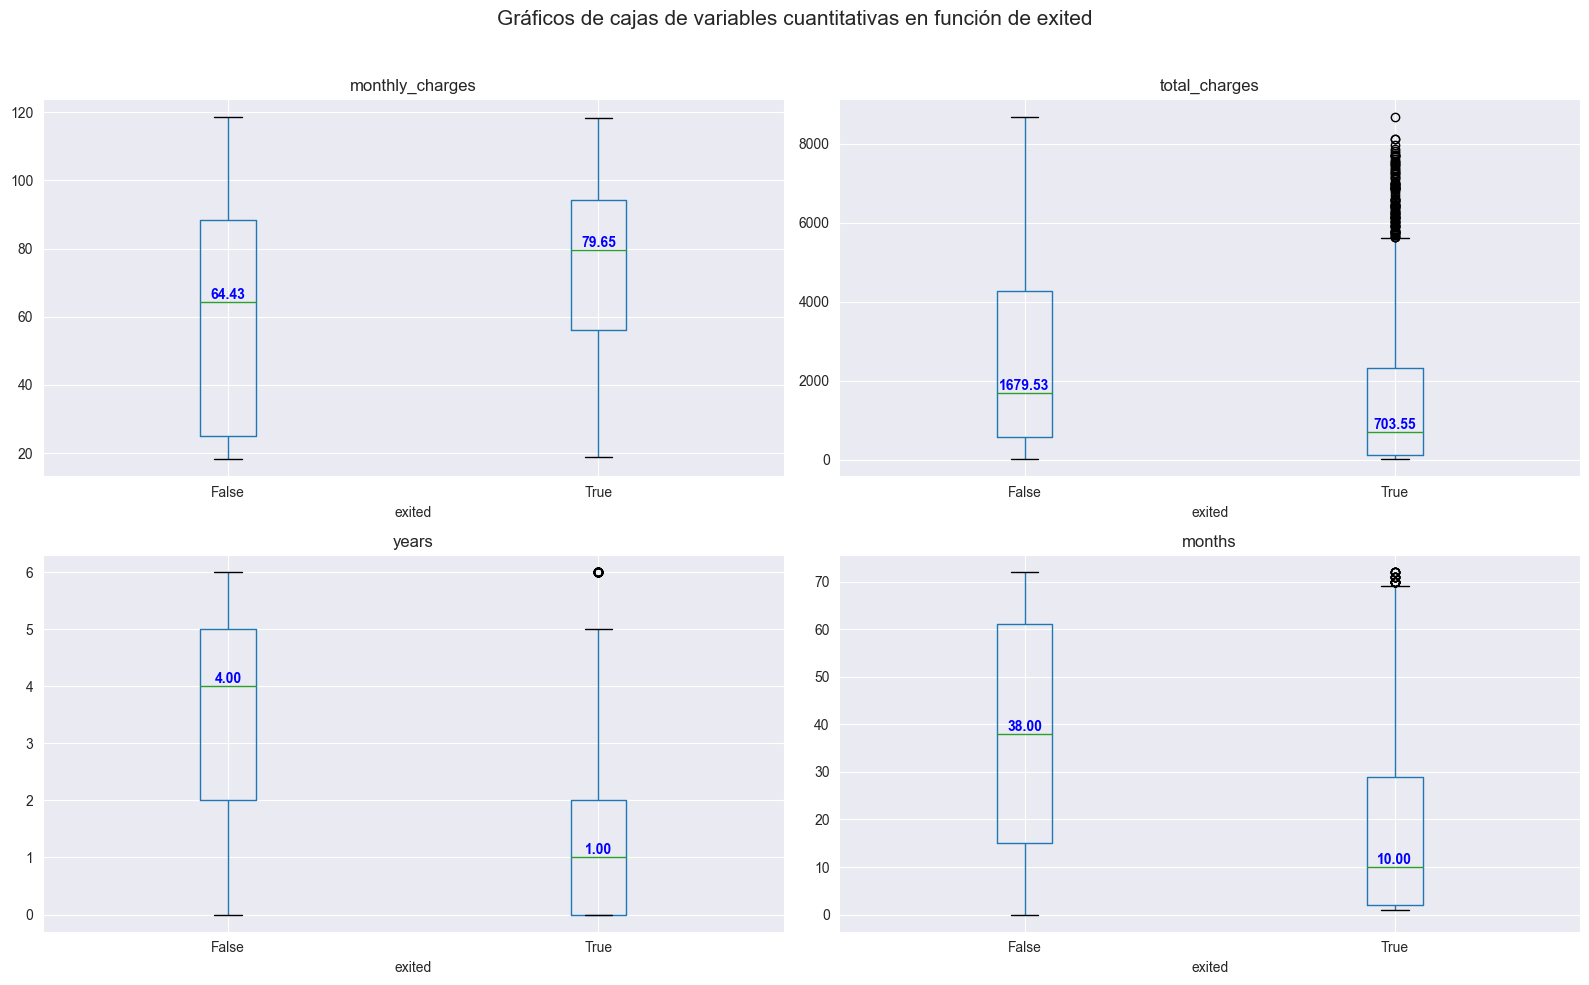

In [40]:
# Configuración de figura y ejes para gráficos de caja
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

# Iteración sobre las variables numéricas para graficar
for n, col in enumerate(num_features):
    ax = axes.flatten()[n]
    
    # Visualización: gráfico de caja agrupado por la variable 'exited'
    df.boxplot(column=col, by='exited', ax=ax)
    ax.set_title(col)
    
    # Cálculo de medianas por grupo 'exited'
    medians = df.groupby('exited')[col].median()
    
    for x_pos, (exited_val, median_val) in enumerate(medians.items(), start=1):
        ax.text(x_pos, median_val, f'{median_val:.2f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='blue')

# Título general
plt.suptitle('Gráficos de cajas de variables cuantitativas en función de exited', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

La gráfica de boxplots complementa y visualiza claramente los hallazgos del análisis de correlación punto-biserial. Se observa que los clientes que permanecen tienen periodos de servicio significativamente más largos en años y meses, con medianas notablemente superiores a las de quienes cancelaron, lo que coincide con las correlaciones negativas moderadas señaladas. Asimismo, los totales cobrados a clientes activos son considerablemente mayores, reflejando la relación inversa entre total charges y cancelación. Por otro lado, los cargos mensuales muestran medianas algo más elevadas en el grupo que canceló, apoyando la correlación positiva aunque débil encontrada. En conjunto, estas evidencias visuales y cuantitativas subrayan la importancia de la duración y la estructura de cargos para entender y prevenir la pérdida de clientes.

## Análisis de la variable objetivo

Finalizaremos el análisis exploratorio con un estudio detallado de la distribución de la variable objetivo, con el fin de identificar posibles desbalances entre las clases. Esta evaluación es fundamental para entender si los datos presentan una proporción equilibrada entre clientes que permanecen y aquellos que han cancelado el servicio, lo cual impacta directamente en la selección y desempeño de los modelos predictivos.

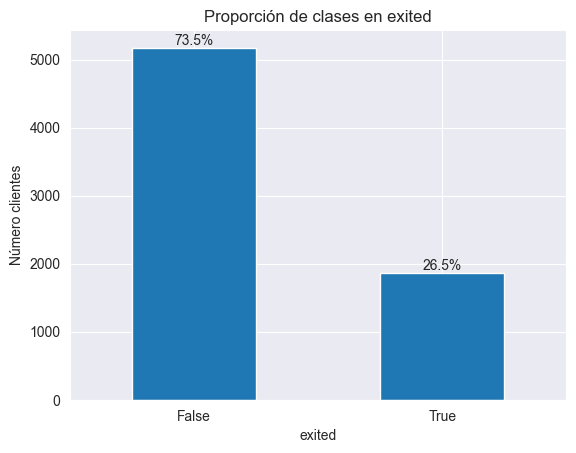

In [41]:
# Cálculo de frecuencias de valores en la columna 'exited' del DataFrame
counts = df['exited'].value_counts()

# Visualización con gráfico de barras de la proporción de cada clase en 'exited'
ax = counts.plot(kind='bar', rot=0, title='Proporción de clases en exited')
plt.ylabel('Número clientes')

# Cálculo de porcentajes
total = counts.sum()
for p in ax.patches:
    height = p.get_height()
    percent = height / total * 100
    ax.text(p.get_x() + p.get_width() / 2, height, f'{percent:.1f}%', 
            ha='center', va='bottom', fontsize=10)

plt.show()


Existe un moderado desbalance en las clases, con una tasa de cancelación del 26.5% frente al 73.5% de clientes que mantienen sus cuentas activas. Aunque comúnmente se recomienda aplicar técnicas como submuestreo, sobremuestreo o ajuste de pesos en las clases para mejorar el desempeño del modelo, en este proyecto no las emplearemos, dado que podrían introducir un sesgo no deseado en los datos. En su lugar, nos enfocaremos en optimizar el rendimiento utilizando ajustes de hiperparámetros y evaluando diversos algoritmos, que incluyen modelos tradicionales, técnicas de potenciación de gradiente y redes neuronales. Además, implementaremos validación cruzada y métricas robustas para garantizar la generalización del modelo y evitar sobreajuste, asegurando así resultados confiables y representativos para la predicción del comportamiento de cancelación.

## Observaciones

* En la sección 'Visualización de tasa de cancelación' se presentado un análisis minucioso de la tasa de cancelación de clientes desglosada por diversos subgrupos, mostrando patrones específicos en la captación y abandono de clientes a lo largo del tiempo, **con un punto de inflexión notable en el incremento de cancelaciones desde finales de 2019, lo que sugiere potenciales problemas en la calidad o registro de datos previos.**
  
* Los resultados evidencian que factores como el tipo de contrato, método de pago, grupo demográfico, servicios contratados y cargos mensuales influyen significativamente en la probabilidad de cancelación, destacando, por ejemplo, que mayores compromisos temporales se asocian con menor tasa de abandono, y que clientes con ciertos servicios o métodos de pago presentan tasas más altas de cancelación.

* Se observa una clara tendencia de **mayor retención conforme aumenta la antigüedad del cliente, con la mayoría de las cancelaciones concentrándose en los primeros meses o año de servicio**, lo que indica la importancia crítica de la fidelización temprana para mejorar la estabilidad de la base de clientes y reducir el churn.

* En la sección 'Análisis de correlación entre variable objetivo y distintas categorías' se realizó un análisis exhaustivo de la correlación entre la variable objetivo `'exited'` y diferentes variables numéricas y categóricas, usando métodos estadísticos como la correlación de Pearson para variables numéricas y el estadístico de Cramér's V para variables categóricas. Se destaca que la antigüedad y el compromiso financiero (medidos por tiempo en meses/años y cargos totales) son los factores más influyentes en la permanencia del cliente, con correlaciones negativas moderadas que indican menor probabilidad de cancelación a mayor antigüedad y gasto acumulado.

* En cuanto a variables categóricas, el tipo de contrato muestra la relación más fuerte y moderada con la cancelación, seguida por el método de pago y el tipo de servicio de internet, mientras que factores demográficos tienen poca relevancia. La significancia estadística de estas asociaciones queda respaldada por valores p bajos y chi-cuadrados altos, excepto en variables como género y posesión de teléfono. Estas dos variables serán eliminadas posteriormente.

* Finalmente, el análisis punto-biserial múltiple confirma estas tendencias, mostrando visualmente con boxplots y cuantitativamente la relación inversa entre antigüedad y cancelación, así como una ligera relación directa con cargos mensuales. Además, se identifica un desbalance moderado en la variable objetivo (26.5% cancelación), lo que orienta las estrategias para optimizar modelos predictivos sin recurrir a técnicas de resampling que podrían sesgar los datos.

# Preparación de datos para entrenamiento

Una vez finalizados los procesos de limpieza y preprocesamiento del conjunto de datos, se procederá a su codificación, normalización y posterior división en conjuntos de entrenamiento y prueba.

## Codificación

Se eliminarán las columnas `'customer_id'`, `'begin_date'`, `'end_date'`, `'gender'` y `'phone'` porque son identificadores, porque su información está contenida en otras variables, o porque resultan irrelevantes según el análisis de correlación.

In [42]:
# Eliminación de características irrelevantes para el estudio
df_final = df.drop(['customer_id', 'begin_date', 'end_date', 'gender', 'phone'], axis=1)

cat_features = ['type', 'paperless_billing', 'payment_method', 
                'senior_citizen', 'partner', 'dependents', 
                'internet', 'internet_service', 'online_security', 'online_backup', 
                'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 
                'multiple_lines']

# Comprobación de las nuevas dimensiones del conjunto
df_final.shape

(7043, 20)

Después de aplicar los procesos de limpieza y preprocesamiento, el conjunto de datos final cuenta con 7,043 observaciones y 22 variables.

**OHE**

Se aplica codificación one-hot a las variables categóricas del conjunto de datos utilizando la función get_dummies de pandas. Esta transformación es fundamental para convertir datos no numéricos en un formato adecuado para asegurar que los modelos puedan procesar correctamente las características categóricas y mejorar la calidad de las predicciones.

In [43]:
# Codificación de características categóricas mediante get_dummies
df_ohe = pd.get_dummies(df_final, drop_first=True)
df_ohe.head()

,monthly_charges,total_charges,senior_citizen,exited,internet,years,months,type_One year,type_Two year,paperless_billing_Yes,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,29.85,29.85,0,False,True,0,1,False,False,True,...,False,False,False,False,True,False,False,False,False,False
1,56.95,1889.50,0,False,True,3,34,True,False,False,...,False,False,False,True,False,True,False,False,False,False
2,53.85,108.15,0,True,True,0,2,False,False,True,...,False,False,False,True,True,False,False,False,False,False
3,42.30,1840.75,0,False,True,4,45,True,False,False,...,False,False,False,True,False,True,True,False,False,False
4,70.70,151.65,0,True,True,0,2,False,False,True,...,False,True,False,False,False,False,False,False,False,False


**Ordinal**

Se aplica una codificación ordinal a las variables categóricas utilizando OrdinalEncoder. Esta transformación es fundamental para convertir categorías en valores numéricos ordenados, facilitando que los modelos de predicción basados en algoritmos que requieren entradas numéricas puedan procesar correctamente estos datos.

In [44]:
# Copia del dataset final
df_ordinal = df_final.copy()

# Codificación de características categóricas mediante OrdinalEncoder
encoder = OrdinalEncoder() 
df_ordinal[cat_features] = pd.DataFrame(encoder.fit_transform(df_ordinal[cat_features])) 
df_ordinal.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,internet,years,months
0,0.0,1.0,2.0,29.85,29.85,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False,1.0,0,1
1,1.0,0.0,3.0,56.95,1889.50,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False,1.0,3,34
2,0.0,1.0,3.0,53.85,108.15,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,True,1.0,0,2
3,1.0,0.0,0.0,42.30,1840.75,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,False,1.0,4,45
4,0.0,1.0,2.0,70.70,151.65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1.0,0,2


**Boost**

Se convierte las variables categóricas indicadas en el listado cat_features al tipo de dato 'category'. Esta transformación es relevante porque optimiza el manejo de memoria y facilita el procesamiento eficiente de estas variables en algunos modelos, mejorando el rendimiento y la precisión en las etapas posteriores de predicción.

In [45]:
# Copia del dataset final
df_boost = df_final.copy()

# Transformación de características categóricas a tipo 'category'
for feature in cat_features:
    df_boost[feature] = df_boost[feature].astype('category')

df_boost.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,internet,years,months
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,Yes,No,DSL,No,Yes,No,No,No,No,No,False,True,0,1
1,One year,No,Mailed check,56.95,1889.50,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,True,3,34
2,Month-to-month,Yes,Mailed check,53.85,108.15,0,No,No,DSL,Yes,Yes,No,No,No,No,No,True,True,0,2
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,False,True,4,45
4,Month-to-month,Yes,Electronic check,70.70,151.65,0,No,No,Fiber optic,No,No,No,No,No,No,No,True,True,0,2


## Escalado

A continuación se definirá una función que aplica la estandarización de características numéricas utilizando StandardScaler, que centra los datos en media cero y los escala para tener desviación estándar uno. Escalar los datos es relevante porque muchos algoritmos de aprendizaje automático, especialmente aquellos sensibles a las magnitudes de las variables, requieren que las características estén en la misma escala para evitar que algunas dominen el entrenamiento, mejorando así la convergencia y el rendimiento del modelo.

In [46]:
# Función para escalar características numéricas
def scale_numeric_features(df):
    df_scaled = df.copy()
    scaler = StandardScaler()
    scaler.fit(df_scaled[num_features])
    df_scaled[num_features] = scaler.transform(df_scaled[num_features])
    return df_scaled

In [47]:
# Escalamiento de características numéricas, conjunto OHE
df_ohe_scaled = scale_numeric_features(df_ohe)
df_ohe_scaled.head()

,monthly_charges,total_charges,senior_citizen,exited,internet,years,months,type_One year,type_Two year,paperless_billing_Yes,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,-1.160323,-0.992667,0,False,True,-1.390381,-1.277445,False,False,True,...,False,False,False,False,True,False,False,False,False,False
1,-0.259629,-0.172198,0,False,True,0.037437,0.066327,True,False,False,...,False,False,False,True,False,True,False,False,False,False
2,-0.362660,-0.958122,0,True,True,-1.390381,-1.236724,False,False,True,...,False,False,False,True,True,False,False,False,False,False
3,-0.746535,-0.193706,0,False,True,0.513377,0.514251,True,False,False,...,False,False,False,True,False,True,True,False,False,False
4,0.197365,-0.938930,0,True,True,-1.390381,-1.236724,False,False,True,...,False,True,False,False,False,False,False,False,False,False


In [48]:
# Escalamiento de características numéricas, conjunto Ordinal
df_ordinal_scaled = scale_numeric_features(df_ordinal)
df_ordinal_scaled.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,internet,years,months
0,0.0,1.0,2.0,-1.160323,-0.992667,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False,1.0,-1.390381,-1.277445
1,1.0,0.0,3.0,-0.259629,-0.172198,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False,1.0,0.037437,0.066327
2,0.0,1.0,3.0,-0.362660,-0.958122,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,True,1.0,-1.390381,-1.236724
3,1.0,0.0,0.0,-0.746535,-0.193706,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,False,1.0,0.513377,0.514251
4,0.0,1.0,2.0,0.197365,-0.938930,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,1.0,-1.390381,-1.236724


In [49]:
# Escalamiento de características numéricas, conjunto Boost
df_boost_scaled = scale_numeric_features(df_boost)
df_boost_scaled.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,internet,years,months
0,Month-to-month,Yes,Electronic check,-1.160323,-0.992667,0,Yes,No,DSL,No,Yes,No,No,No,No,No,False,True,-1.390381,-1.277445
1,One year,No,Mailed check,-0.259629,-0.172198,0,No,No,DSL,Yes,No,Yes,No,No,No,No,False,True,0.037437,0.066327
2,Month-to-month,Yes,Mailed check,-0.362660,-0.958122,0,No,No,DSL,Yes,Yes,No,No,No,No,No,True,True,-1.390381,-1.236724
3,One year,No,Bank transfer (automatic),-0.746535,-0.193706,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,False,True,0.513377,0.514251
4,Month-to-month,Yes,Electronic check,0.197365,-0.938930,0,No,No,Fiber optic,No,No,No,No,No,No,No,True,True,-1.390381,-1.236724


## Divisón en conjuntos de entrenamiento y prueba

A continuación, se procederá a segmentar los conjuntos de datos escalados y codificados mediante diferentes técnicas, separándolos en subconjuntos de entrenamiento (80%) y prueba (20%). Estos conjuntos permitirán evaluar de manera robusta el desempeño de los modelos de predicción seleccionados. 

In [50]:
# Función para la división de datos en características y variable objetivo
def divide_train_test(df, target='exited', test_size=0.2, random_state=12345):
   
    x = df.drop(target, axis=1)
    y = df[target]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=random_state)

    print(f'Tamaño del conjunto de entrenamiento: {x_train.shape}, {y_train.shape}')
    print(f'Tamaño del conjunto de prueba: {x_test.shape}, {y_test.shape}')

    return x_train, x_test, y_train, y_test

In [51]:
# Preparación de conjuntos de entrenamiento y prueba para datos codificados
x_train_ohe, x_test_ohe, y_train_ohe, y_test_ohe = divide_train_test(df_ohe)
x_train_ord, x_test_ord, y_train_ord, y_test_ord = divide_train_test(df_ordinal)
x_train_boost, x_test_boost, y_train_boost, y_test_boost = divide_train_test(df_boost)

Tamaño del conjunto de entrenamiento: (5634, 23), (5634,)
Tamaño del conjunto de prueba: (1409, 23), (1409,)
Tamaño del conjunto de entrenamiento: (5634, 19), (5634,)
Tamaño del conjunto de prueba: (1409, 19), (1409,)
Tamaño del conjunto de entrenamiento: (5634, 19), (5634,)
Tamaño del conjunto de prueba: (1409, 19), (1409,)


# Entrenamiento y prueba de modelos

## Procedimientos de evaluación

Antes de proceder con el desarrollo de los modelos predictivos, es fundamental establecer funciones que permitan medir y evaluar objetivamente su desempeño.

### 1. Función para búsqueda de hiperparámetros con validación cruzada

La función realizará una búsqueda exhaustiva de hiperparámetros para un estimador dado utilizando validación cruzada de 5 pliegues, evaluando el desempeño mediante la métrica AUC-ROC. Tras entrenar con todas las combinaciones posibles, identificará y mostrará los mejores parámetros y la mejor puntuación obtenida. Esto permitirá optimizar la configuración de los modelos para mejorar su capacidad predictiva.


In [52]:
# Función para búsqueda de hiperparámetros con validación cruzada
def model_gridsearch(estimator_name, params, x_train, y_train, model_name):
    
    # Configuración del GridSearchCV con el estimador, parámetros, métrica y número de folds
    grid_search= GridSearchCV(
        estimator=estimator_name,
        param_grid=params,
        scoring= 'roc_auc',
        cv=5)

    # Entrenamiento de los modelos con distintas combinaciones de hiperparámetros
    grid_search.fit(x_train, y_train)

    # Obtención del mejor modelo, mejor puntuación y mejores parámetros
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    # Impresión de resultados óptimos
    print(f'Mejores Hiperparámetros {model_name}: {best_params}')
    print(f'Mejor AUC-ROC CV {model_name}: {best_score:.4f}')
    
    return

### 2. Función para evaluar el modelo con métricas clasificatorias

La función evaluará cada modelo de clasificación utilizando diferentes métricas como precisión, sensibilidad, F1, área bajo la curva ROC y precisión promedio (APS) para ambos conjuntos de entrenamiento y prueba. Además, generará visualizaciones gráficas de estas métricas y almacenará un resumen tabular de los resultados en un dataframe global para facilitar comparaciones.

In [53]:
# Creación de dataframe para almacenar métricas de evaluación de modelos
model_eval = pd.DataFrame(columns=['model', 'ROC_train', 'accuracy_train', 'ROC_test', 'accuracy_test', ])

# Función para evaluar el modelo con métricas clasificatorias
def evaluate_model(model, train_features, train_target, test_features, test_target, model_name):
    
    global model_eval

    # Diccionario para almacenar estadísticas de evaluación
    eval_stats = {}
    
    # Creación de figura con 3 subgráficos para métricas visuales
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    # Bucle para evaluar tanto datos de entrenamiento como de prueba
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        # Predicción de etiquetas y probabilidades
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # Cálculo de valores F1 para distintos umbrales de clasificación
        f1_thresholds = np.arange(0, 1.01, 0.1)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # Cálculo de curva ROC y área bajo la curva ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Cálculo de curva Precision-Recall y promedio de precisión (APS)
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        # Definición de color según tipo de datos para graficar
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Gráfico de evolución del valor F1 en función del umbral
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # Gráfico de la curva ROC con marcadores en umbrales destacados
        ax = axs[1]  
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        for threshold in ( 0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Gráfico de la curva Precision-Recall con marcadores en umbrales destacados
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')  

        # Cálculo y almacenamiento de métricas con predicción de clases
        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
        eval_stats[type]['Precisión'] = metrics.precision_score(target, pred_target)
        eval_stats[type]['Sensibilidad'] = metrics.recall_score(target, pred_target)

    # Creación de dataframe resumen para métricas
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'Sensibilidad', 'Precisión', 'F1', 'APS', 'ROC AUC'))

    # Visualización tabular de las métricas
    display(df_eval_stats)

    # Agregado de nueva fila con resultados al dataframe de evaluación
    new_row = pd.DataFrame({
        'model': [model_name],
        'ROC_train': [df_eval_stats['train']['ROC AUC']],
        'ROC_test': [df_eval_stats['test']['ROC AUC']],
        'accuracy_train': [df_eval_stats['train']['Exactitud']],
        'accuracy_test': [df_eval_stats['test']['Exactitud']],
    })

    model_eval = pd.concat([model_eval, new_row], ignore_index=True)

    # Llamada a función externa para mostrar matriz de confusión
    cf_matrix(model, train_features, train_target, test_features, test_target, model_name)
    
    return 

### 3. Función para visualización de matrices de confusión

La función generará visualizaciones de matrices de confusión para cada modelo, mostrando tanto el desempeño en el conjunto de entrenamiento como en el de prueba.

In [54]:
# Función para visualización de matrices de confusión
def cf_matrix(model, train_features, train_target, test_features, test_target, model_name):
    
    # Configuración de la figura y los subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Matriz de confusión para el conjunto de entrenamiento
    ax = axs[0]
    ConfusionMatrixDisplay.from_estimator(model, train_features, train_target,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 ax=ax)
    ax.set_title('Entrenamiento')
    ax.grid(False)
    
    # Matriz de confusión para el conjunto de prueba
    ax = axs[1]
    ConfusionMatrixDisplay.from_estimator(model, test_features, test_target,
                                 display_labels=[0,1],
                                 cmap=plt.cm.Blues,
                                 ax=ax)
    ax.set_title('Prueba')
    ax.grid(False)

    # Título general para ambas matrices de confusión con el nombre del modelo
    plt.suptitle(f'Matrices de confusión {model_name}')
    
    return 

## Modelos de predicción

Para abordar esta tarea de clasificación se seleccionó una variedad de modelos que cubren enfoques estadísticos clásicos, árboles de decisión, ensamblados y redes neuronales, permitiendo así explorar una amplia gama de paradigmas de aprendizaje y capacidades. 

* La **regresión logística** ofrece un modelo lineal sencillo y eficiente para problemas con relaciones lineales entre variables.

* El **árbol de decisión** proporciona interpretabilidad y captura relaciones no lineales de manera intuitiva.

* Los métodos de ensamblado como **bosque aleatorio** mejoran la precisión mediante la combinación de múltiples árboles, manejando bien la complejidad y el sesgo-variancia.

* **LightGBM, CatBoost, XGBoost** e **HistGradientBoosting** son modelos de aprendizaje automático basados en técnicas de *gradient boosting* que combinan múltiples árboles de decisión para mejorar la precisión en tareas de clasificación y regresión

* Finalmente, el **MLPClassifier** introduce una arquitectura de red neuronal capaz de modelar patrones complejos y no lineales que los otros métodos podrían perder.

### 0. Modelo Dummy

En primer lugar, se empleará un modelo Dummy que únicamente realiza predicciones negativas. Este modelo servirá como línea base para comparar y evaluar el desempeño de los modelos posteriores.

In [55]:
# Establecimiento de características y objetivo para modelo Dummy
x = df_final.drop('exited', axis=1)
y = df_final['exited']

# División de conjuntos de entrenamiento y prueba 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=12345)

# Comprobación de la correcta división de los datos
print(f'Tamaño del conjunto de entrenamiento: {x_train.shape}, {y_train.shape}')
print(f'Tamaño del conjunto de prueba: {x_test.shape}, {y_test.shape}')

Tamaño del conjunto de entrenamiento: (5634, 19), (5634,)
Tamaño del conjunto de prueba: (1409, 19), (1409,)


,train,test
Exactitud,0.74,0.73
Sensibilidad,0.00,0.00
Precisión,0.00,0.00
F1,0.00,0.00
APS,0.26,0.27
ROC AUC,0.50,0.50


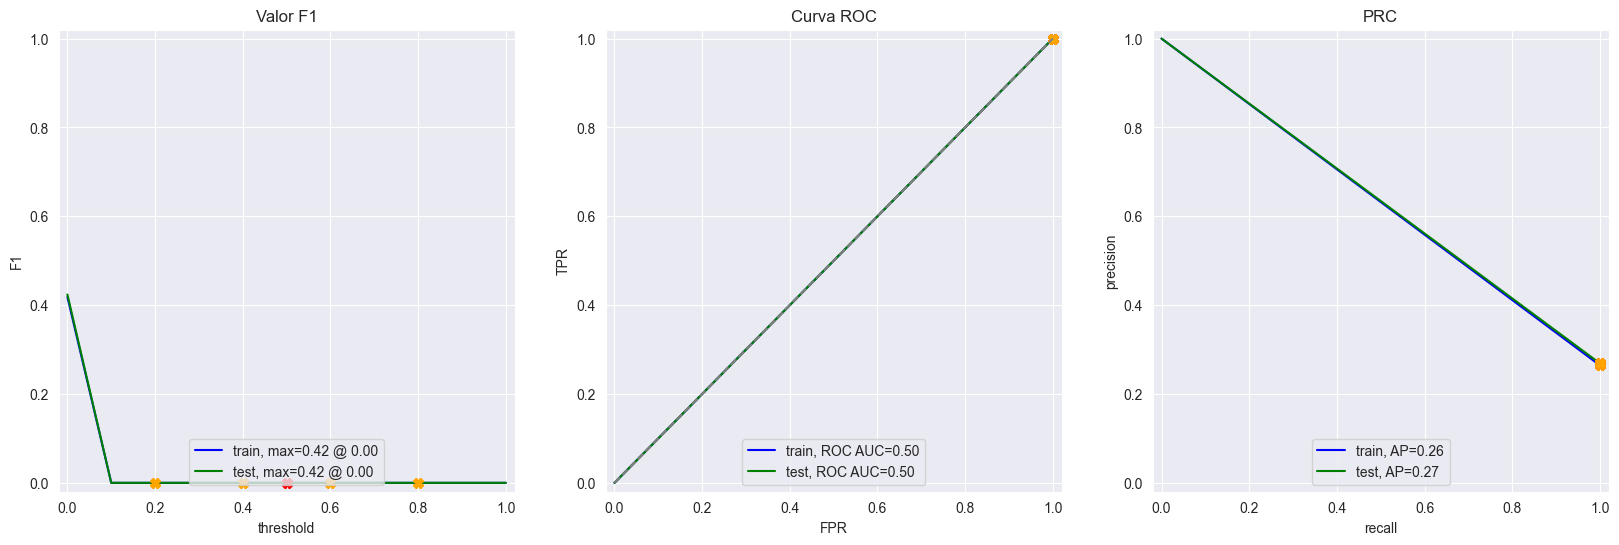

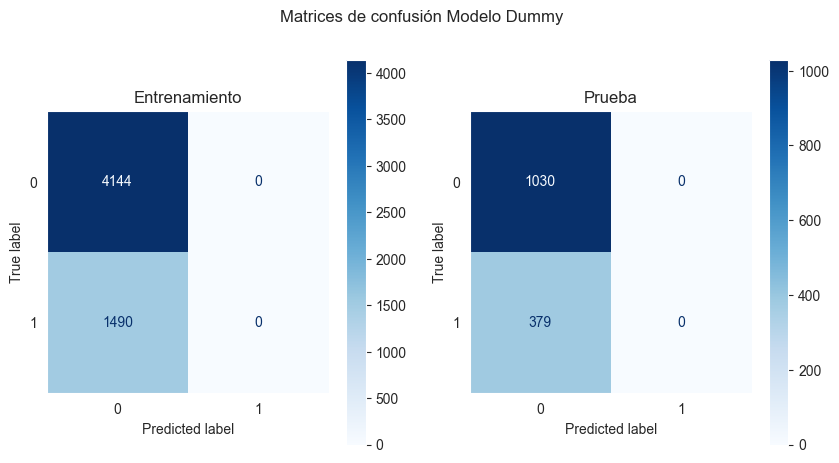

In [56]:
# Entrenamiendo del modelo con estrategia 'constant'
model_dummy = DummyClassifier(strategy='constant', constant=0)
model_dummy.fit(x_train, y_train)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(model_dummy, x_train, y_train, x_test, y_test, 'Modelo Dummy')

**Valor F1:** Las líneas de F1 muestran un valor máximo muy bajo cerca del umbral 0, indicando que el modelo tiene un rendimiento prácticamente nulo para identificar correctamente la clase positiva en cualquier punto. La caída abrupta y constante hacia cero para el resto de los umbrales refleja que el modelo no logra un balance entre precisión y recall, consistentemente asignando negativos. La superposición de las curvas de entrenamiento y prueba confirma la total ausencia de aprendizaje, dado que el modelo dummy simplemente predice siempre la clase negativa.

**Curva ROC:** Las líneas en la curva ROC siguen la diagonal, lo que indica que el modelo no tiene capacidad para distinguir entre clases positivas y negativas; su desempeño es equivalente al azar. Tanto para entrenamiento como para prueba, el Área Bajo la Curva es 0.50, lo que confirma que el modelo no aporta información predictiva y no discrimina entre las clases.

**Curva PRC:** Las curvas de precisión y recall comienzan en 1 y descienden linealmente a un valor bajo de precisión. El área bajo la curva promedio (AP) es muy baja (alrededor de 0.26 y 0.27), lo que indica que el modelo realiza una gran cantidad de falsos negativos sin identificar casos positivos.

**Matrices de confusión:** Las matrices de confusión del modelo dummy muestran que en ambos conjuntos, entrenamiento y prueba, el modelo siempre predice la clase negativa, clasificando correctamente 4144 y 1030 negativos respectivamente, pero sin identificar ningún positivo, ya que todos los casos positivos (1490 en entrenamiento y 379 en prueba) son erróneamente clasificados como negativos. Esta ausencia total de predicciones positivas indica que el modelo no está aprendiendo realmente, sino que simplemente adopta una estrategia trivial basada en la clase mayoritaria. 

### 1. Regresión Logística


El modelo de regresión logística es un clasificador lineal ampliamente utilizado en problemas de clasificación binaria. En este caso, se aplicó regularización L1 (Lasso) para fomentar la reducción y selección automática de coeficientes. Se entrenó utilizando el solver 'liblinear', adecuado para esta regularización y conjuntos de datos de tamaño moderado, y un valor de C alto para permitir cierta flexibilidad en el ajuste del modelo.

,train,test
Exactitud,0.86,0.85
Sensibilidad,0.67,0.66
Precisión,0.78,0.74
F1,0.72,0.70
APS,0.83,0.80
ROC AUC,0.91,0.89


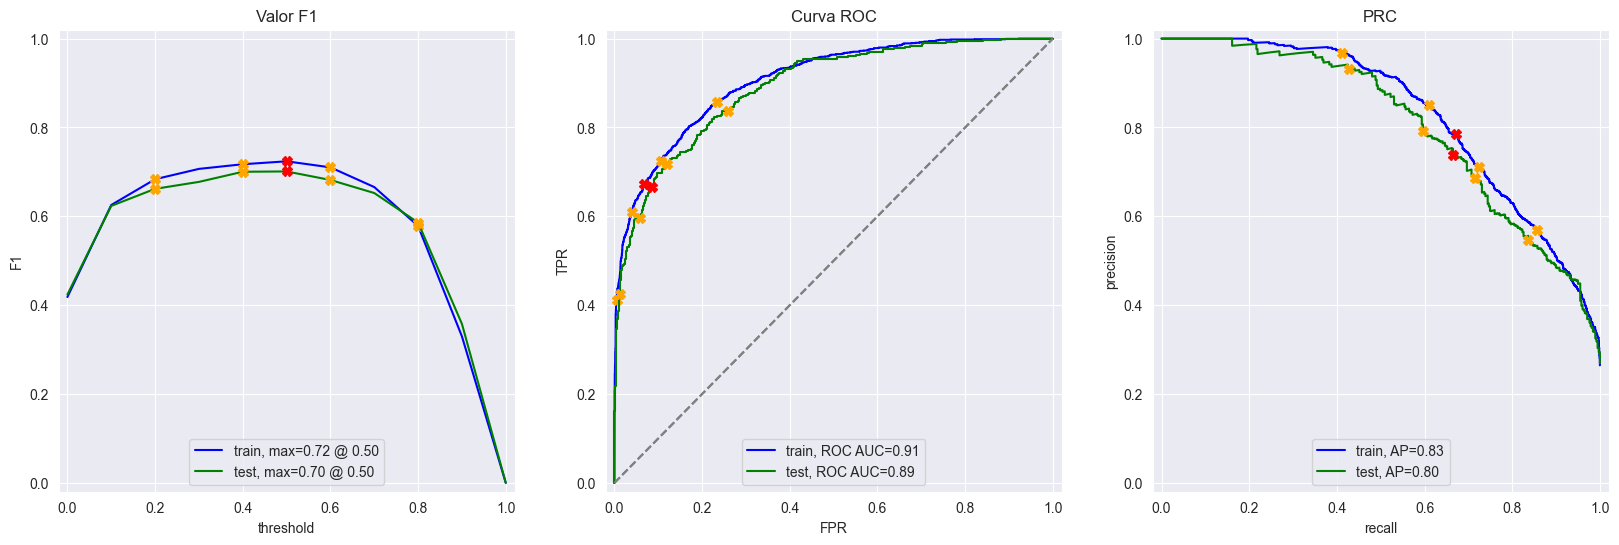

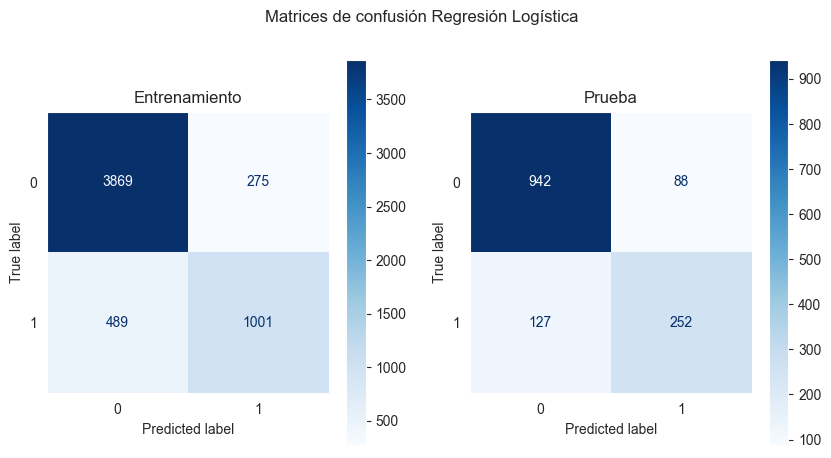

In [57]:
# Entrenamiendo del modelo con los mejores hiperparámetros
lr_model = LogisticRegression(random_state=12345, 
                              solver='liblinear', 
                              penalty= 'l1',
                              l1_ratio = 1.0,
                              max_iter = 300,
                              C= 10)

lr_model.fit(x_train_ohe, y_train_ohe)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(lr_model, x_train_ohe, y_train_ohe, x_test_ohe, y_test_ohe, 'Regresión Logística')

**Valor F1:** La forma de las líneas de entrenamiento y prueba indica que el rendimiento del modelo es máximo en un umbral alrededor de 0.4, con valores de F1 cercanos a 0.72 en entrenamiento y 0.70 en prueba. La caída rápida del F1 hacia los extremos (0 y 1) muestra que el modelo pierde eficacia al clasificar con umbrales demasiado estrictos o permisivos. Los puntos resaltan estos valores máximos y la cercanía entre las curvas sugiere que el modelo no está sobreajustado y generaliza bien.

**Curva ROC:** Las curvas de entrenamiento y prueba se mantienen muy próximas y por encima de la diagonal, indicando equilibrio entre la tasa de verdaderos positivos (TPR) y falsos positivos (FPR). Los puntos resaltados muestran umbrales particulares congruentes en ambas curvas. El AUC-ROC es de aproximadamente 0.91 en entrenamiento y 0.89 en prueba, indicando una alta capacidad del modelo para diferenciar correctamente entre clases positivas y negativas, con solo ligera disminución en datos no vistos.

**Curva PRC:** Las curvas muestran la relación entre precisión y recall, donde el área bajo la curva (AP) es 0.83 para entrenamiento y 0.80 para prueba, reflejando que el modelo mantiene un buen balance para identificar positivos con baja tasa de falsos positivos. La similitud entre líneas indica estabilidad en su rendimiento.

**Matrices de confusión:** Las matrices de confusión muestran que en el conjunto de entrenamiento, el modelo clasifica correctamente 3867 negativos y 999 positivos, con 277 falsos positivos y 491 falsos negativos. En el conjunto de prueba, se observan 942 negativos y 251 positivos correctamente clasificados, con 88 falsos positivos y 128 falsos negativos. Aunque hay una leve disminución en el desempeño en prueba, la diferencia no es marcada, lo que indica que el modelo mantiene un rendimiento consistente sin evidencia clara de sobreentrenamiento. En resumen, el modelo presenta un balance razonable entre sensibilidad y especificidad en ambos conjuntos, sin indicios robustos de sobreajuste.

### 2. Árbol de decisión

El modelo evaluado es un árbol de decisión, un algoritmo supervisado que realiza predicciones clasificando los datos mediante una estructura jerárquica de decisiones basadas en sus características. Los rangos de hiperparámetros explorados, como el criterio de división, la profundidad máxima y el número mínimo de muestras para dividir o para la hoja, se seleccionan para optimizar el equilibrio entre el ajuste del modelo y su capacidad de generalización. Esto permite encontrar la configuración que maximice el rendimiento, evitando tanto el sobreajuste como un modelo demasiado simple.

In [58]:
# Rango de hiperparámetros para el árbol de decisión
params_dt = {'criterion': ['gini', 'entropy'],
             'max_depth': [8, 10, 12] ,
             'min_samples_split': [2, 4, 8],
             'min_samples_leaf': [8, 12, 14],
             'random_state' : [12345]}

# Búsqueda de hiperparámetros con validación cruzada
model_gridsearch(DecisionTreeClassifier(random_state=12345), params_dt, 
                 x_train_ord, y_train_ord, 'Árbol de Decisión')

Mejores Hiperparámetros Árbol de Decisión: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 14, 'min_samples_split': 2, 'random_state': 12345}
Mejor AUC-ROC CV Árbol de Decisión: 0.8837


,train,test
Exactitud,0.89,0.87
Sensibilidad,0.63,0.62
Precisión,0.92,0.87
F1,0.75,0.73
APS,0.88,0.82
ROC AUC,0.94,0.89


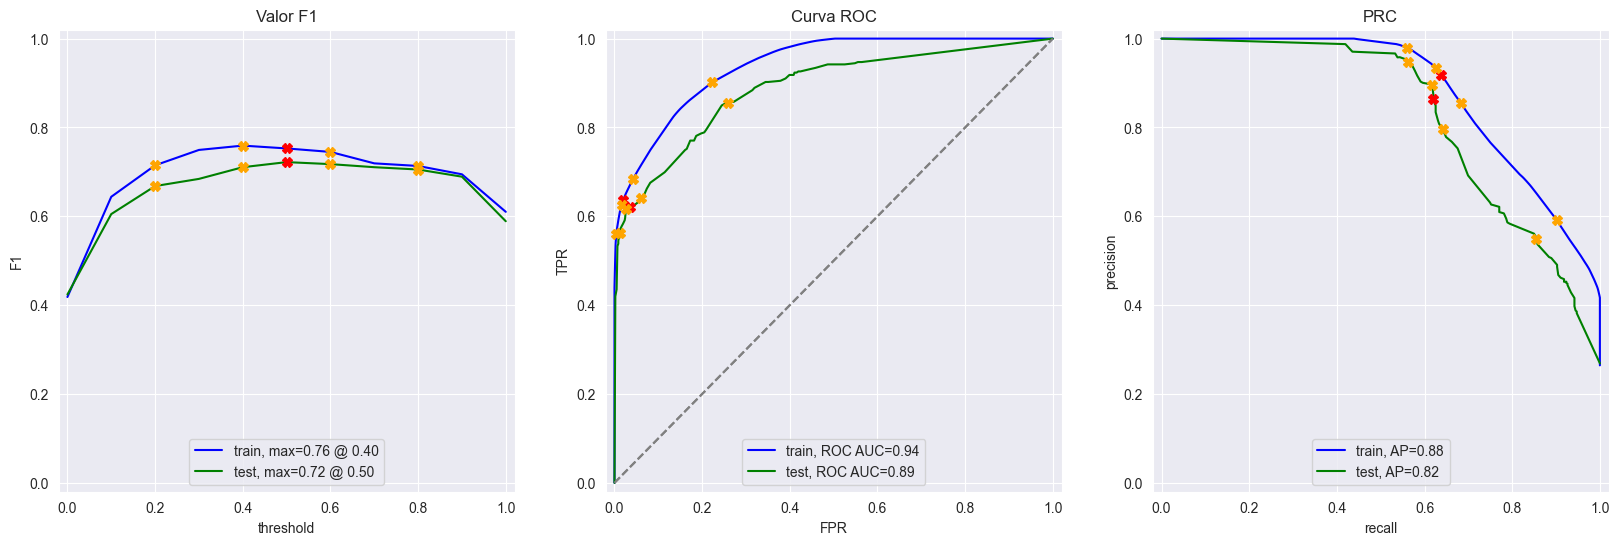

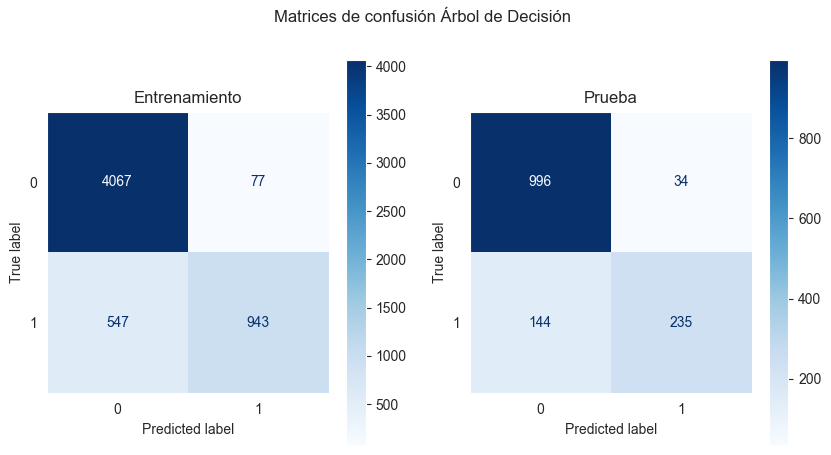

In [59]:
# Entrenamiendo del modelo con los mejores hiperparámetros
dt_model = DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=10, 
                                  min_samples_leaf=14, 
                                  min_samples_split=2,
                                  random_state=12345)

dt_model.fit(x_train_ord, y_train_ord)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(dt_model, x_train_ord, y_train_ord, x_test_ord, y_test_ord, 'Árbol de Decisión')

**Valor F1:** La forma de las líneas muestra que el rendimiento máximo se encuentra alrededor de un umbral de 0.4, con un valor F1 en entrenamiento cercano a 0.77 y en prueba cerca de 0.72. Los puntos resaltan estos máximos. La caída de ambas líneas hacia los extremos indica que en umbrales muy bajos o muy altos el balance entre precisión y recall disminuye. La proximidad entre las curvas de entrenamiento y prueba sugiere que el modelo generaliza bien, sin sobreajuste significativo.

**Curva ROC:** Las líneas de entrenamiento y prueba suben rápidamente con una tasa de verdaderos positivos alta (TPR) y tasa de falsos positivos (FPR) baja, evidenciando buen desempeño discriminativo. Los puntos destacados marcan umbrales específicos concordantes en ambas curvas. El AUC-ROC es 0.94 para entrenamiento y 0.89 para prueba, lo que indica que el modelo distingue muy bien entre clases positivas y negativas, manteniendo estabilidad en datos no vistos.

**Curva PRC:** El área bajo la curva promedio (AP) es 0.88 para entrenamiento y 0.82 para prueba, reflejando que el modelo mantiene un buen equilibrio para identificar positivos con una tasa aceptable de falsos positivos. La similitud entre ambas curvas habla de un rendimiento estable y robusto.

**Matrices de confusión:** Las matrices de confusión muestran que en el conjunto de entrenamiento el modelo clasifica correctamente 4048 negativos y 967 positivos, con 96 negativos y 523 positivos mal clasificados. En el conjunto de prueba, los aciertos son 989 negativos y 239 positivos, con 41 y 140 errores respectivamente. Aunque el desempeño disminuye en prueba, la caída no es excesiva, indicando que el modelo mantiene buena capacidad de generalización. Sin embargo, la mayor proporción de falsos negativos en ambos conjuntos sugiere que el modelo es más conservador en detectar positivos. En general, no se observa un sobreentrenamiento evidente.

### 3. Bosque aleatorio

Este modelo emplea un clasificador Random Forest, que consiste en un conjunto de árboles de decisión entrenados con diferentes subconjuntos del conjunto de datos para mejorar la precisión y reducir el riesgo de sobreajuste. Se exploran los rangos de hiperparámetros como el número de árboles, la profundidad máxima, y los criterios para dividir los nodos, con el fin de encontrar la configuración que optimice el rendimiento del modelo. Estas exploraciones permiten equilibrar la complejidad y la generalización, asegurando que el modelo aprenda patrones relevantes sin ajustarse excesivamente a los datos de entrenamiento.

In [60]:
# Rango de hiperparámetros para el bosque aleatorio
params_rf = {'n_estimators': [100, 150, 200],    
             'max_depth': [None, 10, 20],
             'min_samples_leaf': [3, 5, 7],      
             'min_samples_split': [2, 4, 6],   
             'criterion': ['entropy'],     
             'max_features': ['sqrt', 0.3, 0.5], 
             'random_state' : [12345]}

# Búsqueda de hiperparámetros con validación cruzada
model_gridsearch(RandomForestClassifier(), params_rf, x_train_ord, y_train_ord, 'Bosque Aleatorio')

Mejores Hiperparámetros Bosque Aleatorio: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 12345}
Mejor AUC-ROC CV Bosque Aleatorio: 0.9175


,train,test
Exactitud,0.91,0.88
Sensibilidad,0.69,0.61
Precisión,0.95,0.90
F1,0.80,0.73
APS,0.93,0.85
ROC AUC,0.97,0.92


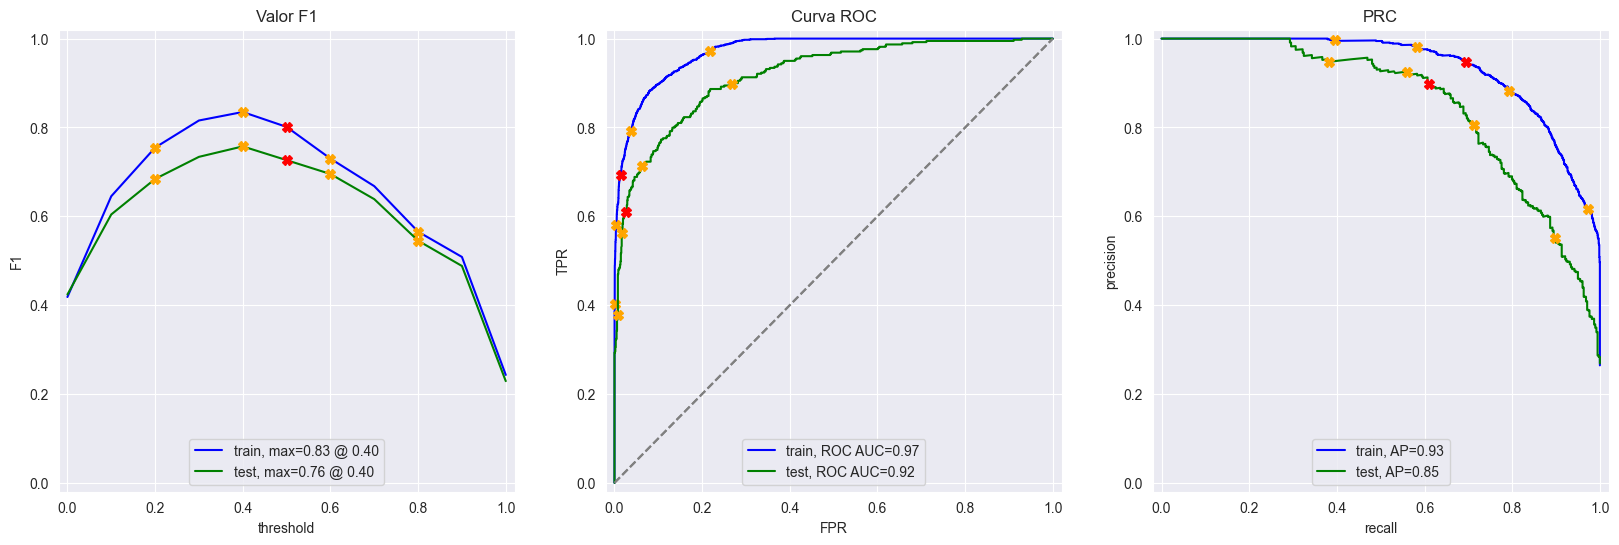

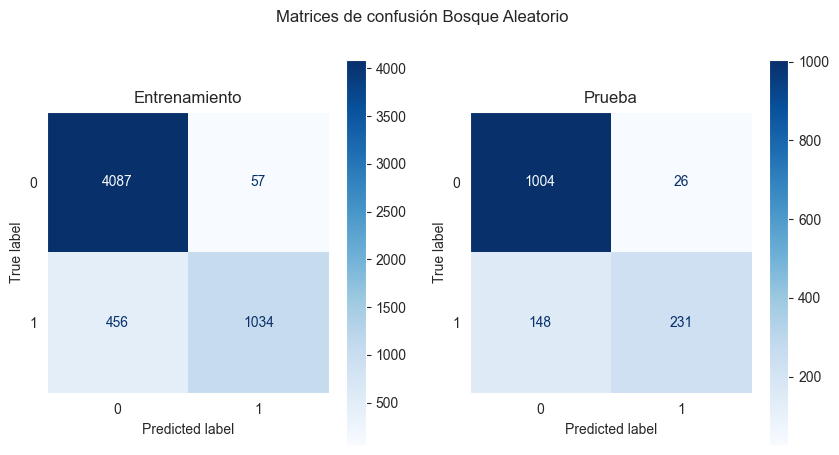

In [61]:
# Entrenamiendo del modelo con los mejores hiperparámetros
rf_model = RandomForestClassifier(criterion='entropy', 
                                  max_depth=10, 
                                  max_features=0.5,
                                  min_samples_leaf=3,
                                  min_samples_split=2,
                                  n_estimators=200, 
                                  random_state=12345)

rf_model.fit(x_train_ord, y_train_ord)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(rf_model, x_train_ord, y_train_ord, x_test_ord, y_test_ord, 'Bosque Aleatorio')

**Valor F1:** Las curvas de valor F1 para entrenamiento y prueba muestran un máximo claro alrededor del umbral 0.4, donde ambas líneas alcanzan valores elevados y cercanos entre sí. Esto indica que en ese umbral el modelo logra un buen equilibrio entre precisión y recall. La separación entre las líneas de entrenamiento y prueba en la gráfica de valor F1 alrededor del umbral 0.4 indica que, en ese punto específico, el modelo tiene un desempeño algo mejor en los datos de entrenamiento que en los datos de prueba. La disminución en ambos extremos (valores muy bajos o muy altos del umbral) refleja que el modelo pierde capacidad de clasificación balanceada, y la similitud de las curvas indica buen ajuste y generalización entre conjuntos.

**Curva ROC:** Las curvas ROC de entrenamiento y prueba presentan un comportamiento muy cercano, con un área bajo la curva (AUC) alta (aproximadamente 0.97 para entrenamiento y 0.92 para prueba). Esto sugiere que el modelo discrimina muy bien entre clases positivas y negativas, manteniendo una alta tasa de verdaderos positivos (TPR) y baja tasa de falsos positivos (FPR). La pequeña diferencia en AUC indica que el modelo puede estar ligeramente sobreajustado, pero en general su desempeño es robusto.

**Curva PRC:** Las curvas de precisión-recall muestran un área promedio (AP) alta, de 0.94 en entrenamiento y 0.85 en prueba, lo que indica que el modelo es eficaz para identificar correctamente la clase positiva sin generar muchos falsos positivos. La caída progresiva de la precisión al aumentar el recall es esperada, reflejando el compromiso típico entre capturar más positivos y mantener precisión. La consistencia entre ambas curvas respalda la buena generalización del modelo.

**Matrices de confusión:** Las matrices de confusión indican que en el conjunto de entrenamiento el modelo clasifica correctamente 4092 negativos y 1021 positivos, con 52 falsos positivos y 469 falsos negativos. En el conjunto de prueba, mantiene un rendimiento similar, con 1004 negativos y 228 positivos bien clasificados, y un aumento moderado en los errores de 26 falsos positivos y 151 falsos negativos. La caída en la capacidad de detección de positivos entre entrenamiento y prueba es moderada, pero no drástica, lo que sugiere que el modelo generaliza razonablemente bien. No se observan indicios claros de sobreentrenamiento.

### 4. LightGBM

LightGBM es un modelo de clasificación basado en el algoritmo de potenciación de gradiente que construye árboles de decisión para mejorar progresivamente la precisión de las predicciones. Este modelo es eficiente y rápido, adecuado para manejar grandes volúmenes de datos y permite controlar la complejidad mediante hiperparámetros que ajustan aspectos como la profundidad del árbol y la tasa de aprendizaje. La exploración de rangos en estos hiperparámetros busca optimizar el rendimiento del modelo, equilibrando su capacidad para aprender patrones relevantes sin caer en sobreajuste ni perder precisión, garantizando así una mejor generalización en datos no vistos.

In [62]:
# Rango de hiperparámetros para LightGBM
params_lightgbm = {'objective': ['binary'],
                   'num_leaves': [7, 10, 15],            
                   'learning_rate': [0.05, 0.1, 0.15],     
                   'n_estimators': [80, 100, 120],        
                   'max_depth': [5, 10, -1],           
                   'min_child_samples': [3, 5, 7],    
                   'random_state':[12345]}

# Búsqueda de hiperparámetros con validación cruzada
model_gridsearch(LGBMClassifier(verbose=-1), params_lightgbm, x_train_boost, y_train_boost, 'LightGBM')

Mejores Hiperparámetros LightGBM: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 3, 'n_estimators': 120, 'num_leaves': 7, 'objective': 'binary', 'random_state': 12345}
Mejor AUC-ROC CV LightGBM: 0.9384


,train,test
Exactitud,0.91,0.90
Sensibilidad,0.72,0.70
Precisión,0.93,0.90
F1,0.81,0.79
APS,0.92,0.88
ROC AUC,0.96,0.93


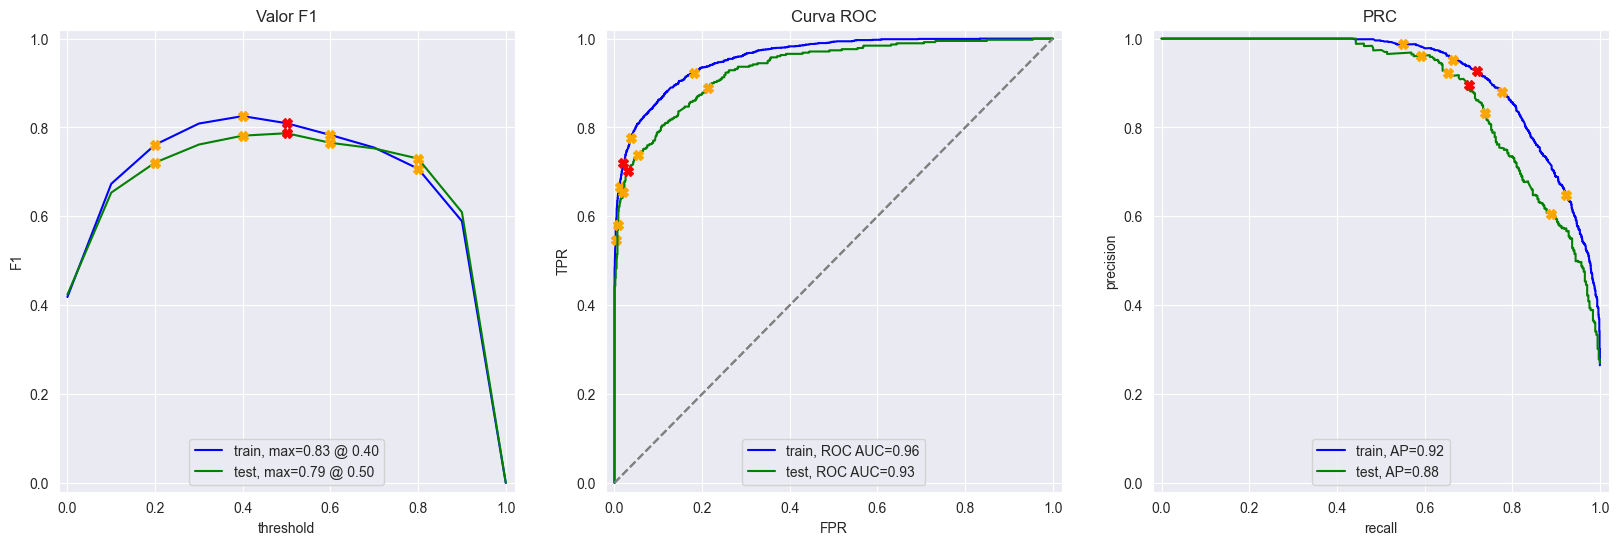

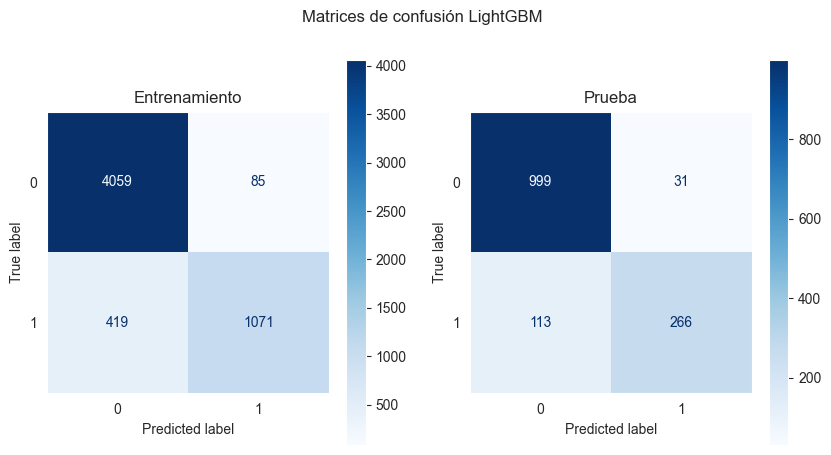

In [63]:
# Entrenamiendo del modelo con los mejores hiperparámetros
lightgbm_model = LGBMClassifier(objective='binary',
                                max_depth = 5,
                                min_child_samples = 3,
                                n_estimators=120, 
                                learning_rate=0.1,
                                num_leaves=7,
                                random_state=12345,
                                verbose=-1)

lightgbm_model.fit(x_train_boost, y_train_boost)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(lightgbm_model, x_train_boost, y_train_boost, x_test_boost, y_test_boost, 'LightGBM')

**Valor F1:** La forma de las líneas indica que el rendimiento es óptimo cerca de un umbral de 0.4, donde ambas curvas se aproximan y alcanzan su máximo. La caída pronunciada al acercarse a extremos (0 y 1) refleja que con umbrales muy bajos o muy altos el modelo pierde capacidad para balancear bien las clasificaciones. La similitud entre entrenamiento y prueba sugiere buen ajuste y generalización.

**Curva ROC:** Las líneas muestran que tanto el modelo entrenado como el probado mantienen una alta TPR con un FPR bajo, lo que indica buen desempeño discriminativo. La proximidad de ambas curvas indica consistencia del modelo entre entrenamiento y prueba. El Área Bajo la Curva (AUC-ROC) es de aproximadamente 0.93-0.96, lo que significa que el modelo tiene una alta capacidad para distinguir correctamente entre clases positivas y negativas.

**Curva PRC:** Las curvas de entrenamiento y prueba siguen un patrón donde el área bajo la curva (AP o área promedio) es alta (0.93 para entrenamiento y 0.88 para prueba), sugiriendo que el modelo mantiene un buen equilibrio para identificar correctamente las clases positivas sin generar demasiados falsos positivos. La caída hacia la derecha revela que al aumentar el recall es inevitable una reducción en la precisión, pero el modelo logra mantener un rendimiento sólido.

**Matrices de confusión:** Las matrices de confusión indican que en el conjunto de entrenamiento el modelo clasifica correctamente 4064 negativos y 1079 positivos, con 80 falsos positivos y 411 falsos negativos. En el conjunto de prueba, el rendimiento baja ligeramente, con 998 negativos y 265 positivos bien clasificados, y 32 falsos positivos y 114 falsos negativos. La diferencia en la precisión entre entrenamiento y prueba no es significativa, lo que sugiere que el modelo mantiene una buena capacidad de generalización sin signos evidentes de sobreentrenamiento. En conjunto, el modelo presenta un desempeño consistente y equilibrado en ambas fases, con un manejo razonable de falsos positivos y negativos.

### 5. CatBoost

CatBoost es un algoritmo de aprendizaje automático supervisado que utiliza árboles de decisión potenciados mediante gradiente para tareas de clasificación, con especial capacidad para manejar variables categóricas sin necesidad de preprocesamiento manual. Los rangos de los hiperparámetros se exploran para encontrar la configuración que optimice el rendimiento del modelo, ajustando aspectos como la profundidad de los árboles, la tasa de aprendizaje y la regularización, con el fin de mejorar la precisión y evitar problemas como el sobreajuste.

In [64]:
# Rango de hiperparámetros para CatBoost
params_catboost = {'iterations': [80, 100, 120],       
                   'depth': [4, 6, 8],                  
                   'learning_rate': [0.1, 0.2, 0.3],   
                   'l2_leaf_reg': [0.5, 1, 2],          
                   'loss_function': ['Logloss'],
                   'random_state':[12345]}

# Inicialización del clasificador CatBoost
catboost_est = CatBoostClassifier(cat_features=cat_features, 
                                   verbose=False, 
                                   loss_function='Logloss',
                                   eval_metric='AUC')

# Búsqueda de hiperparámetros con validación cruzada
model_gridsearch(catboost_est, params_catboost, x_train_boost, y_train_boost, 'CatBoost')

Mejores Hiperparámetros CatBoost: {'depth': 4, 'iterations': 120, 'l2_leaf_reg': 0.5, 'learning_rate': 0.2, 'loss_function': 'Logloss', 'random_state': 12345}
Mejor AUC-ROC CV CatBoost: 0.9397


,train,test
Exactitud,0.91,0.90
Sensibilidad,0.73,0.71
Precisión,0.93,0.89
F1,0.82,0.79
APS,0.92,0.89
ROC AUC,0.95,0.94


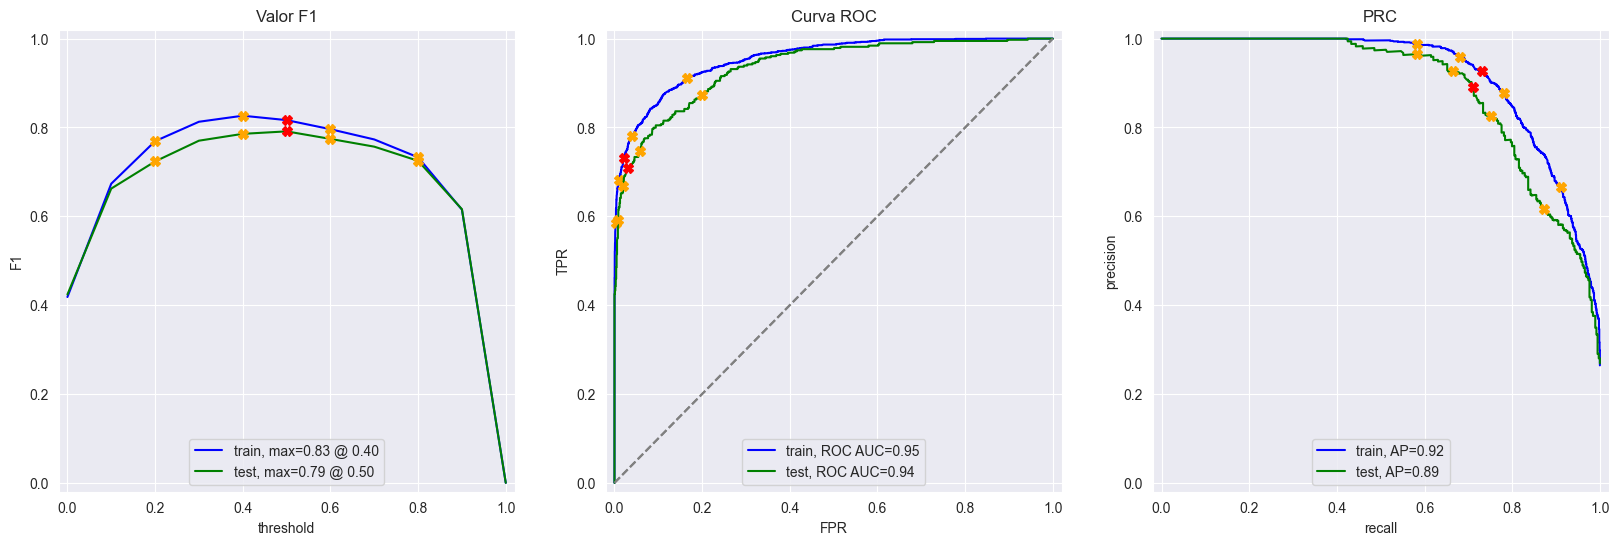

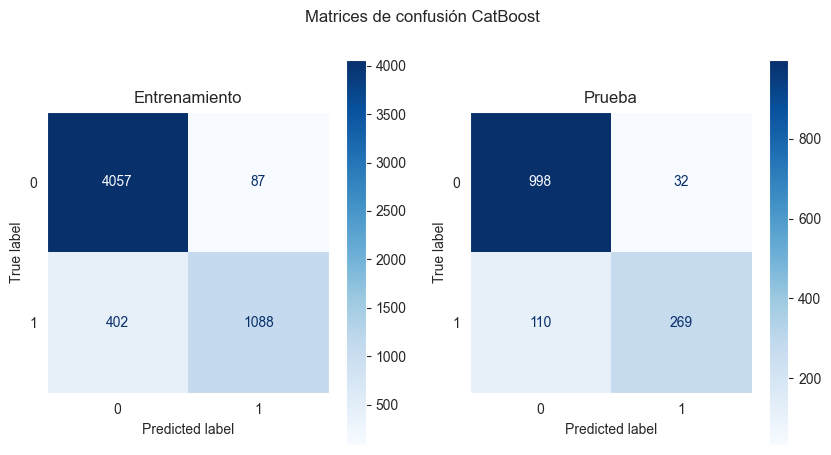

In [65]:
# Entrenamiendo del modelo con los mejores hiperparámetros
catboost_model = CatBoostClassifier(random_state=12345,
                                    iterations=120, 
                                    verbose=False, 
                                    depth=4,
                                    l2_leaf_reg=0.5,
                                    learning_rate=0.2,
                                    loss_function='Logloss',
                                    eval_metric='AUC')

catboost_model.fit(x_train_boost, y_train_boost, cat_features=cat_features, verbose=False)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(catboost_model, x_train_boost, y_train_boost, x_test_boost, y_test_boost, 'CatBoost')

**Valor F1:** Las líneas revelan que el rendimiento máximo se alcanza alrededor de un umbral de 0.4, punto donde ambas curvas convergen y alcanzan su mayor valor. La caída marcada cerca de los extremos (0 y 1) indica que al usar umbrales muy bajos o muy altos el modelo pierde efectividad para equilibrar la clasificación. La cercanía entre las curvas de entrenamiento y prueba refleja un buen ajuste y capacidad de generalización.

**Curva ROC:** Tanto las líneas de entrenamiento como de prueba muestran una alta tasa de verdaderos positivos (TPR) combinada con una baja tasa de falsos positivos (FPR), lo que se traduce en buen poder discriminativo. La semejanza entre ambas curvas evidencia estabilidad del modelo. El AUC-ROC ronda entre 0.94 y 0.96, indicando que el modelo discrimina adecuadamente entre clases positivas y negativas.

**Curva PRC:** En ambas curvas, el área bajo la curva promedio (AP) es alta (0.93 para entrenamiento y 0.89 para prueba), lo que sugiere que el modelo identifica correctamente la clase positiva manteniendo bajo el número de falsos positivos. La pendiente descendente hacia la derecha refleja que al aumentar el recall la precisión tiende a disminuir, pero el modelo conserva un desempeño robusto.

**Matrices de confusión**: Las matrices de confusión indican que el modelo clasifica correctamente la mayoría de los negativos en ambos conjuntos: 4082 en entrenamiento y 997 en prueba. También identifica bien los positivos, con 1098 aciertos en entrenamiento y 270 en prueba, aunque comete algunos errores: 62 negativos se clasificaron erróneamente como positivos en entrenamiento, y 33 en prueba; mientras que 392 positivos se clasificaron como negativos en entrenamiento, y 109 en prueba. La diferencia en desempeño entre entrenamiento y prueba es pequeña y esperable, sin indicios claros de sobreentrenamiento. 

### 6. XGBoost

El modelo XGBoost (eXtreme Gradient Boosting) es un algoritmo supervisado de clasificación que combina múltiples árboles de decisión entrenados secuencialmente para corregir los errores de los anteriores. Los rangos explorados en los hiperparámetros buscan optimizar aspectos clave como la profundidad de los árboles, la tasa de aprendizaje y la regularización, con el fin de mejorar el rendimiento general y evitar problemas como el sobreajuste o la convergencia insuficiente.

In [66]:
# Rango de hiperparámetros para XGBoost
params_xgboost = {'max_depth': [3, 4, 5],             
                  'learning_rate': [0.05, 0.1, 0.15],
                  'n_estimators': [80, 100, 120],    
                  'gamma': [0, 0.1, 0.2],          
                  'reg_alpha': [0.5, 1, 1.5],         
                  'reg_lambda': [0.3, 0.5, 0.7],     
                  'random_state': [12345]}

# Búsqueda de hiperparámetros con validación cruzada
model_gridsearch(XGBClassifier(), params_xgboost, x_train_ohe, y_train_ohe, 'XGBoost')

Mejores Hiperparámetros XGBoost: {'gamma': 0.2, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 120, 'random_state': 12345, 'reg_alpha': 1, 'reg_lambda': 0.3}
Mejor AUC-ROC CV XGBoost: 0.9398


,train,test
Exactitud,0.91,0.90
Sensibilidad,0.73,0.71
Precisión,0.92,0.88
F1,0.82,0.79
APS,0.92,0.88
ROC AUC,0.96,0.93


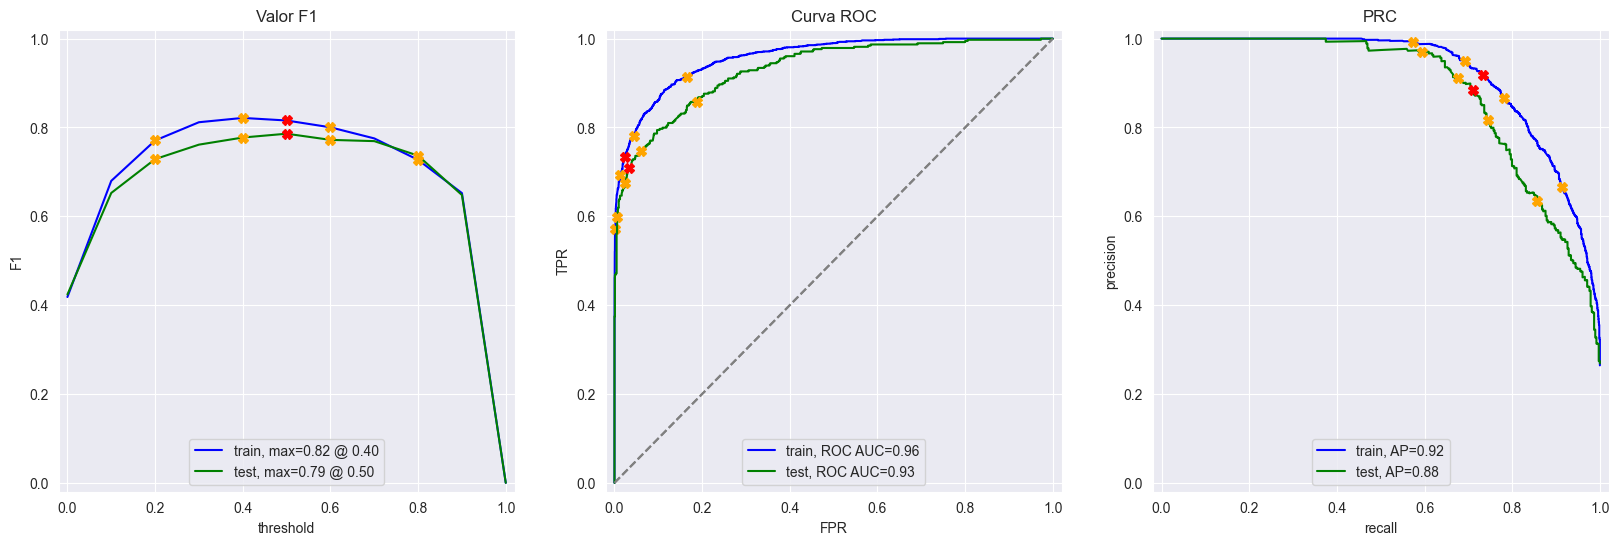

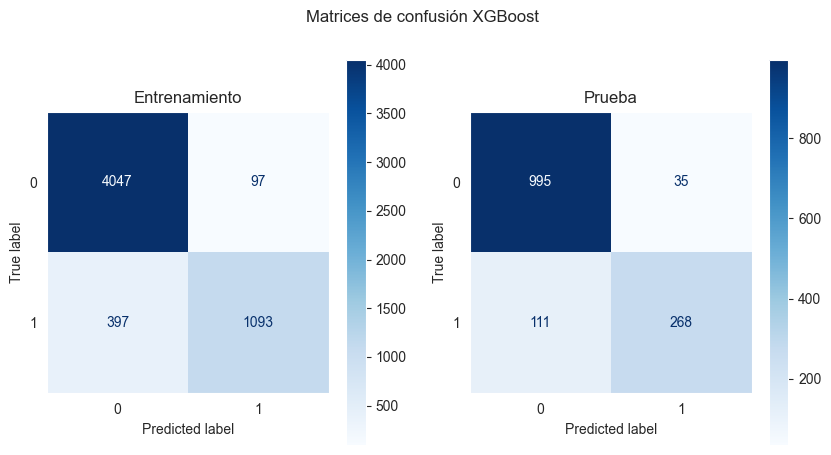

In [67]:
# Entrenamiendo del modelo con los mejores hiperparámetros
xg_model = XGBClassifier(random_state=12345,
                         gamma=0.2,
                         learning_rate=0.15,
                         max_depth=3,
                         n_estimators=120,
                         reg_alpha=1,
                         reg_lambda=0.3)

xg_model.fit(x_train_ohe, y_train_ohe)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(xg_model, x_train_ohe, y_train_ohe, x_test_ohe, y_test_ohe, 'XGBoost')

**Valor F1:** La forma de las líneas señala que el mejor rendimiento se da cerca de un umbral de 0.4, donde las curvas se aproximan y alcanzan su pico máximo. La pronunciada caída hacia los extremos (0 y 1) indica que el modelo pierde capacidad para equilibrar las clases con umbrales demasiado restrictivos o permisivos. La similitud entre las curvas de entrenamiento y prueba indica un adecuado ajuste y buena generalización.

**Curva ROC:** Las curvas de entrenamiento y prueba exhiben una alta tasa de verdaderos positivos y baja tasa de falsos positivos, lo que significa un desempeño discriminativo favorable. La proximidad entre ambas permite inferir estabilidad en el modelo. El AUC-ROC oscila entre 0.93 y 0.96, señal de una notable capacidad para distinguir entre clases positivas y negativas.

**Curva PRC:** Los valores altos del área bajo la curva (AP), 0.92 en entrenamiento y 0.88 en prueba, reflejan que el modelo mantiene un balance apropiado para detectar positivos sin elevar falsos positivos. La tendencia decreciente hacia la derecha indica que conforme sube el recall, la precisión disminuye, pero el rendimiento sigue siendo sólido.

**Matrices de confusión:** Las matrices de confusión indican que en el conjunto de entrenamiento, el modelo clasifica correctamente 4055 negativos y 1086 positivos, con 89 falsos positivos y 404 falsos negativos. En el conjunto de prueba, mantiene un desempeño similar, clasificando bien 995 negativos y 264 positivos, con 35 falsos positivos y 115 falsos negativos. La disminución en exactitud entre entrenamiento y prueba es leve, lo que sugiere una buena capacidad de generalización. No se observan signos evidentes de sobreentrenamiento, ya que el rendimiento es consistente en ambos conjuntos y no hay una caída significativa en la predicción de la clase positiva.

### 7. HistGradientBoostingClassifier

El modelo HistGradientBoostingClassifier es un clasificador basado en el método de potenciación de gradiente que construye secuencialmente árboles de decisión para mejorar iterativamente el rendimiento. Esta implementación optimiza la velocidad y eficiencia mediante el uso de histogramas para manejar grandes volúmenes de datos, manteniendo una buena capacidad predictiva. Los rangos de hiperparámetros seleccionados, como la tasa de aprendizaje, número de iteraciones, profundidad y regularización, se exploran para ajustar el balance entre precisión y generalización, evitando tanto el sobreajuste como un entrenamiento insuficiente.

In [68]:
# Rango de hiperparámetros para HistGradientBoostingClassifier
params_histboost = {'loss': ['log_loss'], 
                    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
                    'max_iter': [50, 100, 150],               
                    'max_leaf_nodes': [10, 15, 30],           
                    'max_depth': [3, 5, 7],                   
                    'l2_regularization': [0.0, 0.1, 1.0],     
                    'random_state': [12345]}

# Búsqueda de hiperparámetros con validación cruzada
model_gridsearch(HistGradientBoostingClassifier(), params_histboost, x_train_ohe, y_train_ohe, 'HistGradientBoostingClassifier')

Mejores Hiperparámetros HistGradientBoostingClassifier: {'l2_regularization': 1.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_iter': 150, 'max_leaf_nodes': 10, 'random_state': 12345}
Mejor AUC-ROC CV HistGradientBoostingClassifier: 0.9374


,train,test
Exactitud,0.91,0.90
Sensibilidad,0.72,0.70
Precisión,0.92,0.89
F1,0.81,0.78
APS,0.91,0.88
ROC AUC,0.96,0.93


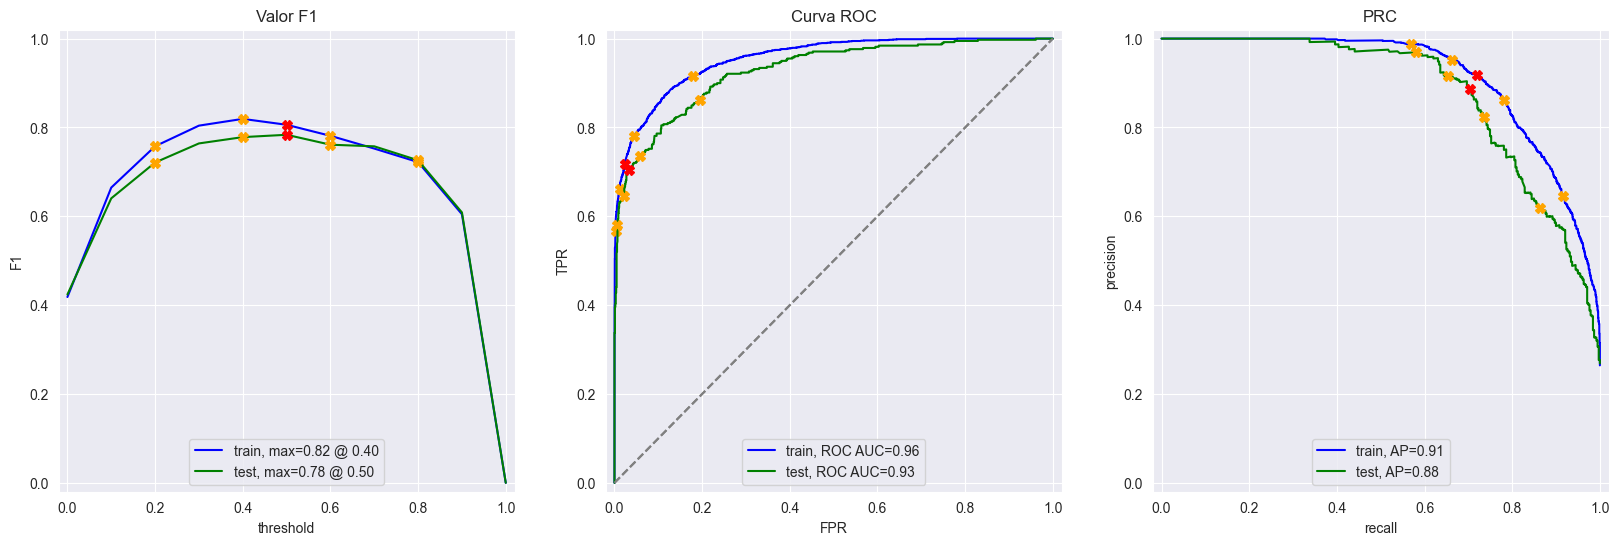

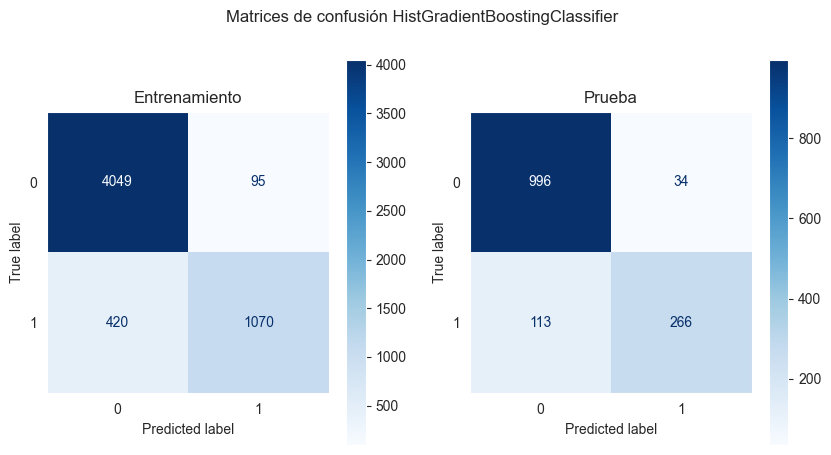

In [69]:
# Entrenamiendo del modelo con los mejores hiperparámetros
hist_model = HistGradientBoostingClassifier(random_state=12345,
                                            l2_regularization=1.0,
                                            loss='log_loss',
                                            learning_rate=0.1,
                                            max_leaf_nodes=10,
                                            max_iter=150,
                                            max_depth=3                      )

hist_model.fit(x_train_ohe, y_train_ohe)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(hist_model, x_train_ohe, y_train_ohe, x_test_ohe, y_test_ohe, 'HistGradientBoostingClassifier')

**Valor F1:** Según la forma de las líneas, el rendimiento óptimo se presenta alrededor del umbral 0.4, donde las curvas convergen y alcanzan su punto más alto. La caída notable en los extremos (0 y 1) representa la dificultad del modelo para mantener un buen equilibrio en clasificaciones con umbrales muy bajos o muy altos. La proximidad de las curvas de entrenamiento y prueba sugiere un modelo bien ajustado y con buena generalización.

**Curva ROC:** Las líneas demuestran que el modelo mantiene una alta tasa de verdaderos positivos con una baja tasa de falsos positivos en ambos conjuntos, entrenamiento y prueba, indicando un buen poder discriminativo. La cercanía relativa entre las curvas refuerza la confianza en el modelo. El AUC-ROC, ubicándose entre 0.93 y 0.96, indica fuerte capacidad para diferenciar clases positivas y negativas correctamente.

**Curva PRC:** Ambas curvas muestran un área bajo la curva (AP) elevada, 0.92 en el entrenamiento y 0.88 en la prueba, evidenciando que el modelo logra identificar la clase positiva eficazmente y con bajo nivel de falsos positivos. La caída hacia la derecha señala la inevitable reducción en precisión al aumentar recall, aunque el desempeño general sigue siendo firme.

**Matrices de confusión:** Las matrices de confusión revelan que el modelo en el conjunto de entrenamiento clasifica correctamente 4056 negativos y 1070 positivos, con 88 falsos positivos y 420 falsos negativos. En el conjunto de prueba, el modelo mantiene un rendimiento similar, con 995 negativos y 265 positivos bien clasificados, y 35 falsos positivos y 114 falsos negativos. La estabilidad en las métricas entre ambos conjuntos indica que el modelo generaliza bien, sin señales claras de sobreentrenamiento.

### 8. MLPClassifier

El modelo de perceptrón multicapa (MLPClassifier) es una red neuronal supervisada utilizada para tareas de clasificación. Este tipo de modelo aprende a partir de datos etiquetados ajustando pesos en múltiples capas ocultas para capturar patrones complejos. Se exploran rangos de hiperparámetros como el tamaño de las capas ocultas, la tasa de regularización, y los parámetros de aprendizaje para encontrar la configuración que optimice el rendimiento del modelo, buscando un balance entre ajuste adecuado y capacidad de generalización. Esta búsqueda permite mejorar la precisión y estabilidad del entrenamiento evitando problemas como el sobreajuste o la convergencia insuficiente.

In [70]:
# Rango de hiperparámetros para MLPClassifier
param_grid = {'hidden_layer_sizes': [(100, 50), (80, 40), (120, 60)],
              'alpha': [0.001, 0.01, 0.05],
              'learning_rate': ['adaptive', 'constant'],
              'learning_rate_init': [0.0005, 0.001, 0.005],
              'solver': ['adam'],
              'activation': ['logistic'],
              'max_iter': [200, 300],
              'random_state': [12345]}

# Búsqueda de hiperparámetros con validación cruzada
model_gridsearch(MLPClassifier(), param_grid, x_train_ohe, y_train_ohe, 'MLPClassifier')

Mejores Hiperparámetros MLPClassifier: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (120, 60), 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005, 'max_iter': 200, 'random_state': 12345, 'solver': 'adam'}
Mejor AUC-ROC CV MLPClassifier: 0.9131


,train,test
Exactitud,0.87,0.85
Sensibilidad,0.62,0.61
Precisión,0.82,0.80
F1,0.71,0.69
APS,0.83,0.81
ROC AUC,0.91,0.90


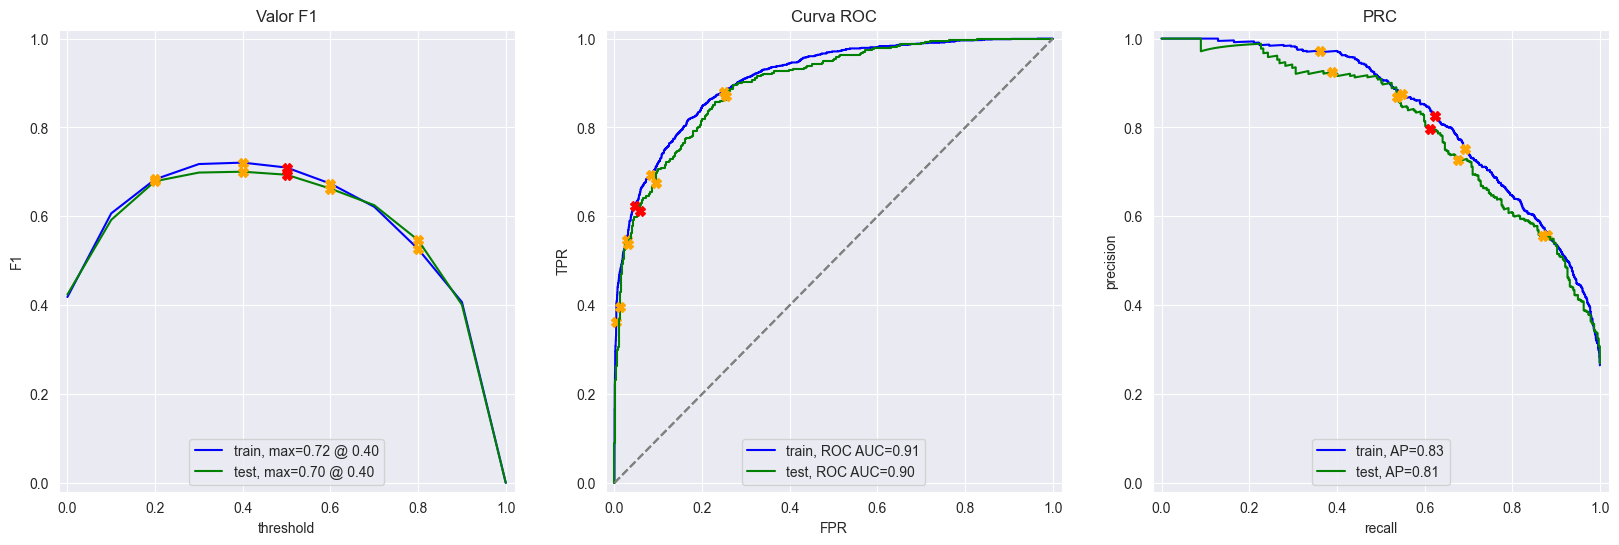

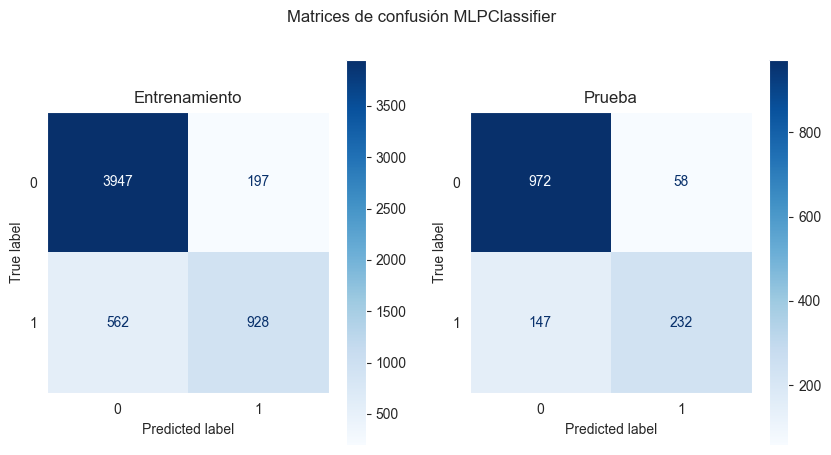

In [71]:
# Entrenamiendo del modelo con los mejores hiperparámetros
mlp_model = MLPClassifier(random_state=12345,
                          hidden_layer_sizes=(120,60),
                          alpha=0.001,
                          learning_rate='adaptive',
                          learning_rate_init = 0.0005,
                          max_iter=200,
                          solver='adam',
                          activation='logistic')

mlp_model.fit(x_train_ord, y_train_ord)

# Evaluación del modelo con el conjunto de prueba
evaluate_model(mlp_model, x_train_ord, y_train_ord, x_test_ord, y_test_ord, 'MLPClassifier')

**Valor F1:** Las curvas de valor F1 para entrenamiento y prueba muestran un comportamiento muy similar, alcanzando un pico máximo alrededor del umbral 0.6, lo que indica que se logra un buen equilibrio entre precisión y recall en ese rango. La caída de las curvas hacia los extremos refleja que al seleccionar umbrales muy bajos o muy altos, el modelo pierde capacidad para clasificar correctamente, ya que prioriza demasiado uno de los dos aspectos. La cercanía de las curvas sugiere buena generalización sin sobreajuste significativo.

**Curva ROC:** Las curvas ROC presentan un comportamiento suave y ascendente, con áreas bajo la curva (AUC) muy altas y casi idénticas entre entrenamiento (aprox. 0.91) y prueba (0.89). Esto indica que el modelo tiene una gran capacidad para distinguir entre clases positivas y negativas, manteniendo una alta tasa de verdaderos positivos con baja tasa de falsos positivos en ambos conjuntos, lo que señala un desempeño robusto y coherente entre entrenamiento y prueba.

**Curva PRC:** Las curvas precisión-recall son más irregulares y presentan picos y valles, especialmente en el conjunto de prueba, lo cual es común cuando se trabaja con datos desbalanceados o pocos ejemplos positivos. Esta irregularidad se debe a que pequeñas variaciones en el umbral pueden cambiar mucho la precisión o el recall cuando hay pocas muestras positivas. A pesar de esta fluctuación, el área bajo la curva promedio (AP) es alta (0.86 entrenamiento, 0.85 prueba), evidenciando que el modelo mantiene un buen rendimiento para identificar la clase positiva con un balance adecuado entre precisión y recall.

**Matrices de confusión:** Las matrices de confusión muestran que en el conjunto de entrenamiento, el modelo clasifica correctamente 3798 negativos y 1113 positivos, con errores de 346 negativos mal clasificados como positivos y 377 positivos mal clasificados como negativos. En el conjunto de prueba, las cifras bajan proporcionalmente, con 941 negativos y 278 positivos correctamente clasificados, y 89 y 101 errores, respectivamente. La disminución relativa en el desempeño entre entrenamiento y prueba no es muy pronunciada, lo que sugiere que el modelo generaliza razonablemente bien sin una clara evidencia de sobreentrenamiento.

# Evaluación de desempeño de modelos

Con base en los resultados obtenidos de los distintos modelos evaluados, se identificará el que ofrezca el mejor desempeño para predecir con precisión los usuarios con mayor probabilidad de cancelar su servicio.

,model,ROC_train,accuracy_train,ROC_test,accuracy_test
0,Modelo Dummy,0.50,0.74,0.50,0.73
1,Regresión Logística,0.91,0.86,0.89,0.85
2,Árbol de Decisión,0.94,0.89,0.89,0.87
3,Bosque Aleatorio,0.97,0.91,0.92,0.88
4,LightGBM,0.96,0.91,0.93,0.90
5,CatBoost,0.95,0.91,0.94,0.90
6,XGBoost,0.96,0.91,0.93,0.90
7,HistGradientBoostingClassifier,0.96,0.91,0.93,0.90
8,MLPClassifier,0.91,0.87,0.90,0.85


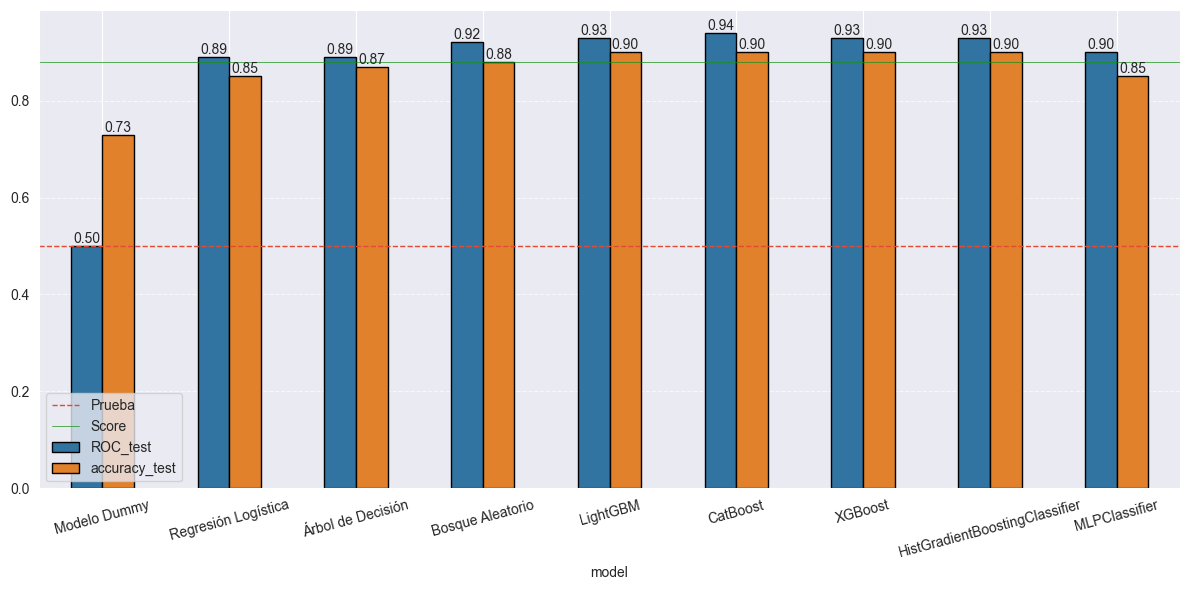

In [72]:
# Resumen de resultados de los modelos
display(model_eval)

# Creación de gráfico de barras comparativo para métricas del modelo
ax = model_eval.plot(x='model', 
                     y=['ROC_test', 'accuracy_test'], 
                     kind='bar', 
                     figsize=(12, 6),
                     rot=15,
                     color=['#3274a1', '#e1812c'],
                     edgecolor='black')

# Etiquetado de barras con valores numéricos con dos decimales
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

# Líneas de referencia horizontales para valores clave en el gráfico
ax.axhline(y=0.5, color='#e14b31', linestyle='--', linewidth=1, label='Prueba')
ax.axhline(y=0.88, color='#169116', linestyle='-', linewidth=.5, label='Score')

ax.legend(loc='lower left')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Para considerar un modelo exitoso, **se estableció el umbral de un ROC superior a 0.88 en el conjunto de prueba, condición que cumplen todos los modelos evaluados.** Destacan especialmente los modelos basados en boosting —LightGBM, CatBoost, XGBoost e HistGradientBoosting—, que alcanzan un ROC aproximado de 0.93 y una exactitud entre 0.89 y 0.90, lo que refleja su capacidad para capturar relaciones complejas en los datos y generalizar eficazmente. Por su parte, la regresión logística y el árbol de decisión presentan un desempeño adecuado, pero inferior en comparación con los métodos de ensamble y la red neuronal (MLPClassifier), cuyo ROC es ligeramente menor pese a mantener una buena exactitud.

En resumen, **CatBoost, LightGBM y XGBoost se posicionan como los modelos mejor calibrados en términos de capacidad discriminativa y exactitud**, seguidos de cerca por HistGradientBoosting. El bosque aleatorio, MLPClassifier, regresión logística y árbol de decisión constituyen alternativas competitivas, aunque con un rendimiento algo menor para esta tarea específica de predicción de cancelación de clientes.

Es importante resaltar la relación observada entre sensibilidad y precisión en todos los modelos, donde la precisión fue mayor mientras que la sensibilidad fue menor, reflejándose en valores F1 reducidos. Esta situación puede atribuirse al desbalance en las clases, con solo un 26% de usuarios que cancelan sus cuentas. Aunque esta métrica podría mejorarse mediante técnicas como sobremuestreo o ajuste de pesos de clase, en este caso prioritario es maximizar la precisión y la proporción de verdaderos positivos frente a falsos positivos, para identificar con mayor exactitud a los clientes con mayor riesgo de cancelación y así diseñar planes específicos dirigidos a este grupo.

**CatBoost se destaca como el mejor modelo en esta comparación principalmente por su equilibrio sólido entre todas las métricas evaluadas,** mostrando una alta exactitud (0.90 en prueba), sensibilidad (0.71), precisión (0.90), F1 (0.79), APS (0.89) y un ROC AUC robusto (0.94). En comparación con LightGBM y XGBoost, CatBoost mantiene un rendimiento muy cercano, aunque LightGBM y XGBoost presentan marginalmente mayor sensibilidad y ROC AUC; sin embargo, CatBoost supera en precisión y estabilidad general entre entrenamiento y prueba, lo cual indica un menor sobreajuste y mejor generalización. Además, CatBoost posee la ventaja de manejar de manera nativa variables categóricas sin necesidad de preprocesamiento externo, simplificando el flujo de trabajo y reduciendo riesgos de pérdida de información, mientras que LightGBM y XGBoost requieren codificación previa para estas variables. En cuanto a velocidad, aunque LightGBM es conocido por ser más rápido y XGBoost más flexible en ajuste, CatBoost ofrece robustez contra el sobreajuste gracias a técnicas específicas de regularización, con un desempeño particularmente estable en conjuntos de datos con características heterogéneas.

# Conclusiones

**Inicialización**

* Se importaron cuatro bases de datos con información de 7,043 clientes, relativos a datos personales, planes y contratos; se identificó la necesidad de unificar estos datos en un solo conjunto.

* Se procedió a transformar columnas de fechas en formato datetime y a normalizar fechas para cuentas no suspendidas, estableciendo una fecha de referencia fija.

* Se definió la variable objetivo para modelos predictivos a partir de la fecha de finalización de contrato, generando una variable categórica binaria que indica cancelación.

* Se verificó la calidad de los datos en los datasets base, confirmando ausencia de valores faltantes o duplicados y correcta asignación de tipos.

* Se planificó renombrar las columnas para cumplir normas de buenas prácticas de programación y facilitar futuros análisis.

**Preprocesamiento de datos**

* Se fusionaron las cuatro bases en un único dataset de 7,043 usuarios, integrando variables personales, contractuales y de servicios.

* Se aplicaron técnicas de limpieza, como renombrado de columnas en formato *snake_case*, conversión de formatos y creación de variables categóricas para cancelar cuentas.

* Se trataron valores "No" en fechas de fin de contrato, asignándoles una fecha fija y transformándolas en tipo datetime para definir el objetivo predictivo.

* Se imputaron valores faltantes en cargos totales usando cargos mensuales y se convirtieron variables categóricas de servicios en indicadores binarios, completando de forma adecuada las categorías faltantes.

* Se agregó una variable que calcula meses completos de servicio para análisis posteriores relacionados con patrones de gasto y permanencia.



**Análisis exploratorio de datos**

* Se visualizó la tasa de cancelación discriminada por subgrupos, detectando un aumento notable en cancelaciones a partir de finales de 2019, apuntando a posibles problemas en registros previos o cambios en comportamiento.

* Se identificaron variables clave que influyen en la cancelación: tipo de contrato, método de pago, servicios contratados y cargos mensuales, con mayor fidelización en clientes con compromisos temporales prolongados.

* Se observó que la antigüedad del cliente es un factor crítico, con cancelaciones concentradas en los primeros meses o año de servicio, resaltando la importancia de la fidelización temprana.

* Mediante análisis estadísticos (Pearson y Cramér's V) se confirmaron relaciones moderadas y significativas entre la variable objetivo y atributos numéricos y categóricos, descartando variables con baja asociación.

* El análisis punto-biserial múltiple y visualizaciones complementarias reafirmaron la influencia negativa de la antigüedad en la cancelación y una relación positiva leve de cargos mensuales con el churn, además de revelar un desbalance moderado (26.5% cancelación) que orienta estrategias de modelado sin alterar la distribución original.

**Entrenamiento y prueba de modelos**

- En esta sección se desarrolló un análisis exhaustivo de múltiples modelos de clasificación para predecir la cancelación del servicio, explorando desde enfoques básicos como el árbol de decisión, hasta técnicas avanzadas como *gradient boosting* y redes neuronales. Cada modelo fue evaluado con métricas clave (F1, AUC-ROC, PRC) y matrices de confusión, para comparar rendimiento, balance entre precisión y recall, y capacidad de generalización.
  
- El modelo dummy sirvió como línea base, mostrando un desempeño nulo al predecir siempre la clase mayoritaria (no cancelación), lo que resaltó la necesidad de modelos efectivos para discriminar clases.

- Los modelos clásicos (regresión logística, árbol de decisión) demostraron buena capacidad predictiva con valores F1 alrededor de 0.7 en prueba y un equilibrio razonable entre sensibilidad y especificidad, sin sobreajuste evidente.

- Los enfoques basados en ensamblados (bosque aleatorio, LightGBM, CatBoost, XGBoost, HistGradientBoosting) alcanzaron los mejores desempeños, con áreas bajo la curva (AUC) superiores a 0.9, alta estabilidad entre entrenamiento y prueba, y una gestión eficaz del compromiso entre falsos positivos y negativos, aunque con ligeras señales de sobreajuste controlado.

- Finalmente, el MLPClassifier mostró un rendimiento robusto similar a los mejores modelos de boosting, manteniendo buena capacidad discriminativa y generalización, con un comportamiento ligeramente más irregular en métricas relacionadas con datos desbalanceados, pero sin evidencia clara de sobreentrenamiento.


**Evaluación de desempeño de modelos**

* Para evaluar el desempeño de los distintos modelos predictivos para la clasificación de cancelación de clientes, se estableció como criterio de éxito un ROC superior a 0.88 en el conjunto de prueba.

* Los modelos basados en boosting —LightGBM, CatBoost, XGBoost e HistGradientBoosting— lograron el mejor rendimiento, con un ROC entre 0.93 y 0.94 y una exactitud entre 0.89 y 0.90, destacando por su capacidad para captar relaciones complejas y generalizar eficazmente.

* Se identificó un desequilibrio entre sensibilidad y precisión en todos los modelos, con mayor precisión pero menor sensibilidad, lo que se traduce en valores de F1 reducidos, atribuido al desbalance de clases con solo 26% de cancelaciones.

* Aunque técnicas como sobremuestreo o ajuste de pesos podrían mejorar la sensibilidad, en este caso se priorizó maximizar la precisión para identificar con mayor exactitud a los clientes con riesgo de cancelación, facilitando así la implementación de estrategias específicas de retención.

* **CatBoost destaca como el mejor modelo por su equilibrio robusto en métricas** (precisión 0.89, sensibilidad 0.71, F1 0.79, APS 0.89 y ROC AUC 0.94), ofreciendo mayor precisión y estabilidad entre entrenamiento y prueba, lo que indica menor sobreajuste y mejor generalización. Además, maneja variables categóricas de forma nativa, simplificando el preprocesamiento, y brinda un rendimiento confiable incluso en datos heterogéneos, aunque LightGBM es más rápido y XGBoost más flexible para ajuste.

* Sin embargo, cabe recordar la anomalía detectada al visualizar la proporción de cuentas generadas y canceladas por mes. Como se mencionó, **esta aparente falta de cancelaciones durante cinco años debe ser investigada a partir del contexto del negocio y los procesos de gestión de datos para descartar errores o sesgos. Sin dicha revisión, cualquier análisis posterior basado en estos datos podría ser incompleto o engañoso.**